## Imports

In [1]:
# Core Libraries
import itertools
from itertools import combinations
import numpy as np
import pandas as pd

# Visualization
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.graph_objects as go
import seaborn as sns

# IPython / Widgets
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact

# Network Analysis
import networkx as nx

# Machine Learning & Clustering
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Time Series / Probabilistic Models
from pydtmc import MarkovChain
import pydtmc as dtmc
from tslearn.metrics import dtw

# Distance Metrics
from scipy.spatial.distance import jensenshannon

# Feature Engineering
from feature_engine.outliers import OutlierTrimmer

DATA_DIR = 'data'

### Terminal commands to install prerequisites

```console
conda create -n gogymi python=3.12 numpy pandas matplotlib seaborn plotly ipywidgets ipython nbformat networkx scikit-learn tslearn scipy -c conda-forge -y
```

```console
conda activate gogymi
pip install pydtmc feature-engine
```

# Research question

## What are the typical behavioral pathways of a student and how do they affect their learning outcomes?

# Preprocessing

### Load dataframes' relevant columns

In [2]:
activities = pd.read_csv(f'{DATA_DIR}/activity.csv')
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

In [3]:
activities = activities[['user_id', 'course_id', 'activity_type', 'activity_started', 'activity_completed']]
all_scores = all_scores[['user_id', 'course', 'percentage']]

### Remove old dates, outliers, long  and missing durations

- Get only users that have score data
- Exam is irrelevant because it is simple moodle-style pdf access
- Access is always immediately followed by a relevant state such as course, lesson or quiz
- Group progress concerns only teachers
- Durations will be kept in timedelta(ns) to preserve granularity
- Durations_minutes is calculated for visualizations and the trimming
- Trim using typical IQR method and Tukey's rule

In [4]:
# Keep only courses we have scores for
activities = activities[activities['course_id'].isin(all_scores.course.unique())]
# Drop irrelevant activity types
activities = activities[~activities['activity_type'].isin(['exam','group_progress','access'])]

# Calculate activity durations
activities = activities.dropna(subset=['activity_started', 'activity_completed'])
activities['activity_started'] = pd.to_datetime(activities['activity_started'], unit='s')
activities['activity_completed'] = pd.to_datetime(activities['activity_completed'], unit='s')
activities['duration'] = activities['activity_completed'] - activities['activity_started']

# Filter out old dates and irrelevant long durations(more than 24h long means the person might have left and finished on another day)
print(activities.shape)
activities = activities[
    (activities['duration'] >= pd.Timedelta(0)) &
    (activities['duration'] <= pd.Timedelta(hours=24)) &
    (activities['activity_started'].dt.year > 2022)
]
print(activities.shape)

# Utility column in float64 for minutes (instead of the timedelta(ns) duration)
activities['duration_minutes'] = activities['duration'].dt.total_seconds()/60

activities_before = activities.copy()

# Trim outliers
trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5, variables=['duration_minutes'])
activities = trimmer.fit_transform(activities)

print(activities.shape)

(36894, 6)
(23001, 6)
(19929, 7)


In [5]:
activities.describe()

,user_id,course_id,activity_started,activity_completed,duration,duration_minutes
count,19929.000000,19929.000000,19929,19929,19929,19929.000000
mean,2259.083396,2705.129409,2024-11-09 08:55:48.275728640,2024-11-09 09:05:20.817351680,0 days 00:09:32.541622760,9.542360
min,1.000000,42.000000,2023-04-07 16:42:38,2023-04-07 16:43:58,0 days 00:00:02,0.033333
25%,329.000000,42.000000,2024-10-09 10:20:32,2024-10-09 10:30:18,0 days 00:00:54,0.900000
50%,3182.000000,3301.000000,2024-11-14 17:49:04,2024-11-14 17:57:28,0 days 00:04:24,4.400000
75%,3881.000000,3865.000000,2025-01-01 15:58:53,2025-01-01 16:01:31,0 days 00:13:19,13.316667
max,4095.000000,5447.000000,2025-03-07 06:42:09,2025-03-07 06:57:30,0 days 00:55:52,55.866667
std,1721.925101,1972.971233,NaN,NaN,0 days 00:12:11.166207416,12.186103


### Visualize durations distribution before and after

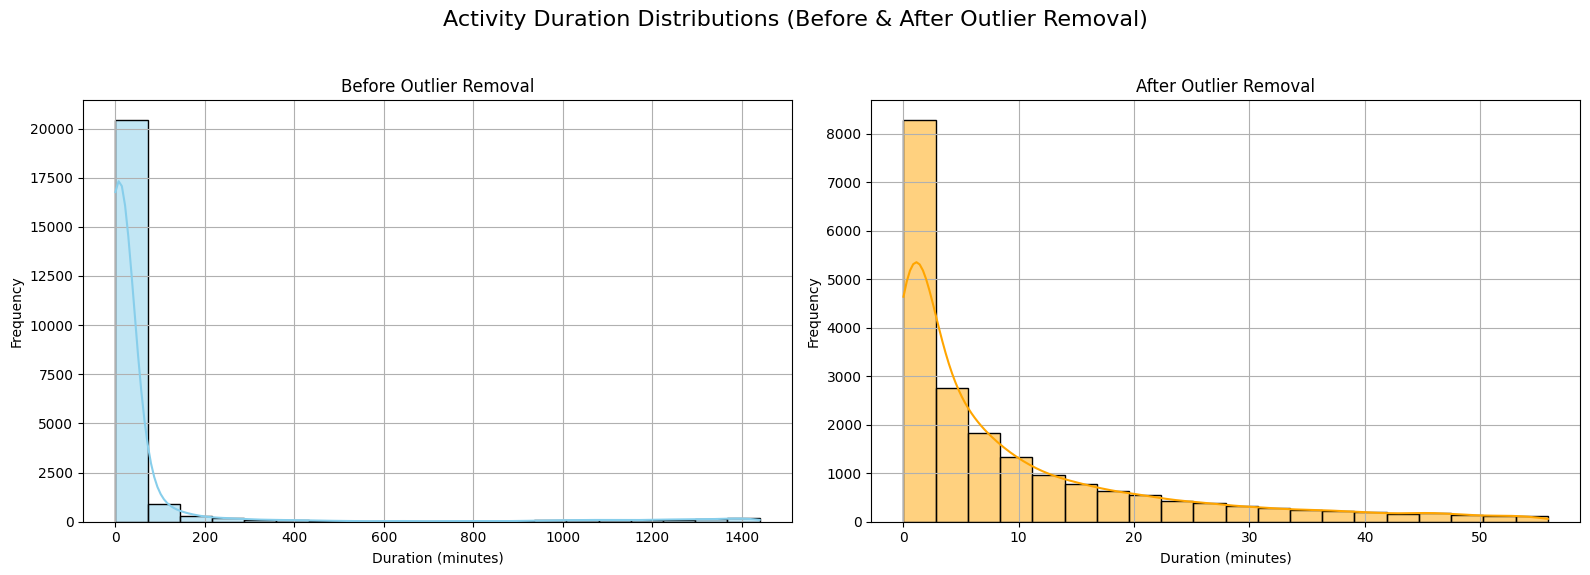

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Activity Duration Distributions (Before & After Outlier Removal)", fontsize=16)

sns.histplot(activities_before['duration_minutes'], bins=20, color='skyblue', ax=axes[0], kde=True)
axes[0].set_title('Before Outlier Removal')
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

sns.histplot(activities['duration_minutes'], bins=20, color='orange', ax=axes[1], kde=True)
axes[1].set_title('After Outlier Removal')
axes[1].set_xlabel('Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Dictionaries for relevant courses (`course_id` -> `name`)

Those are the only courses we are interested in, as they are the only ones covered by the scores

In [7]:
print(f"Scores cover: {all_scores.course.unique()}")

Scores cover: [  42 3865 5009 2115 5447 3301]


In [8]:
# Create mapping course_id -> course name/short name

class SmartMap(dict):
    def __missing__(self, key):
        return f"Unknown({key})"
    
course_map = SmartMap({
    42 : 'Langzeitgymnasium maths',
    3865 : 'Kurzzeitgymnasium maths',
    5447 : 'Langzeitgymnasium essay',
    2115 : 'Langzeitgymnasium text comprehension',
    5009 : 'Kurzzeitgymnasium text comprehension',
    3301 : 'Kurzzeitgymnasium essay',
    1696 : 'Student site introduction',
    8117 : 'Teacher site introduction'
})

course_map_short = SmartMap({
    42 : 'LZG_M',
    3865 : 'KZG_M',
    5447 : 'LZG_E',
    2115 : 'LZG_TC',
    5009 : 'KZG_TC',
    3301 : 'KZG_E',
    1696 : 'SSI',
    8117 : 'TSI'
})

In [9]:
activities_copy = activities.copy(deep=True)

# Cook some dataframes for the clustering

## Inputs

### Brewing of **zduration_sum**

#### For each user, course, and activity type combination, we calculate the z-score relative to the distribution of all users for the same course and activity type.

Using `user_agg` we can choose how we aggregate the durations in case a student has done an activity of the same type and course multiple times

In [10]:
def compute_zduration(df_in, user_agg='sum'):
    """
    Compute z-score normalized duration for each user per (course_id, activity_type) pair.

    Parameters:
        df_in: pd.DataFrame with columns: user_id, course_id, activity_type, duration
        user_agg: str, 'sum' or 'mean'

    Returns:
        pd.DataFrame with: user_id, course_id, activity_type, duration, mean_duration, std_duration, zscore_duration
    """

    # 0. Copy as to not modify the input dataframe
    df = df_in.copy(deep=True)

    # 1. Aggregate per user per (course_id, activity_type)
    user_activity = (
        df.groupby(['user_id', 'course_id', 'activity_type'], as_index=False)
          .agg({'duration': user_agg})
    )

    # 2. Compute mean and std per (course_id, activity_type)
    stats = (
        user_activity.groupby(['course_id', 'activity_type'])['duration']
        .agg(['mean', 'std']).reset_index()
        .rename(columns={'mean': 'mean_duration', 'std': 'std_duration'})
    )

    # 3. Merge
    merged = user_activity.merge(stats, on=['course_id', 'activity_type'], how='left')

    # 4. Z-score
    merged['zscore_duration'] = (merged['duration'] - merged['mean_duration']) / merged['std_duration']

    return merged[['user_id', 'course_id', 'activity_type', 'duration', 'mean_duration', 'std_duration', 'zscore_duration']]


In [11]:
zduration_sum = compute_zduration(activities, 'sum')

In [12]:
zduration_sum.head()

,user_id,course_id,activity_type,duration,mean_duration,std_duration,zscore_duration
0,1,3301,quiz,0 days 00:04:59,0 days 00:06:16.612121212,0 days 00:05:57.196666262,-0.217281
1,1,3301,topic,0 days 00:00:11,0 days 01:01:16.201716738,0 days 00:56:35.367471301,-1.079471
2,1,3865,quiz,0 days 00:19:26,0 days 02:48:46.236607142,0 days 02:33:54.677760883,-0.970281
3,1,3865,topic,0 days 00:56:11,0 days 01:48:34.604095563,0 days 01:46:45.686579520,-0.490752
4,1,5009,topic,0 days 03:05:13,0 days 01:26:28.571428571,0 days 01:28:26.502501462,1.116447


### Brewing of gap_days

We compute the number of days between each user's active sessions to analyze engagement gaps.

Using each user’s first activity per day, we calculate the gap between consecutive active days and store the result as a sorted list per user.

#### i.e. gap_days contains for each user_id an ordered list of the amount of days elapsed between actions

In [13]:
user_daily_activity = activities.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Ceate a csv of user_ids, gap_days where gap_days is a list of the gaps (ignore nans) in increasing order. Use copies of the dataframes
df = user_daily_activity.copy(deep=True)[['user_id', 'gap_days']]
# Remove the first gap_days (nan) for each user
df.dropna(subset=['gap_days'], inplace=True)
# Group by user_id and aggregate the gap_days into a list
df = df.groupby('user_id')['gap_days'].apply(lambda x: list(x)).reset_index()
# Sort the gap_days list for each user
df['gap_days'] = df['gap_days'].apply(lambda x: sorted(x))

gap_days = df.copy(deep=True)

# Save to csv
gap_days.to_csv(f'{DATA_DIR}/user_gap_days.csv', index=False)

In [14]:
gap_days.head()

,user_id,gap_days
0,1,"[1.0, 1.0, 2.0, 2.0, 2.0, 4.0, 4.0, 7.0, 19.0,..."
1,4,"[2.0, 6.0, 7.0, 8.0, 13.0, 51.0]"
2,6,"[2.0, 2.0, 6.0, 6.0, 8.0, 14.0, 20.0, 44.0]"
3,7,"[1.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, ..."
4,9,"[2.0, 7.0, 8.0, 12.0, 18.0, 24.0, 25.0]"


### Brewing of user_chains

The key idea of **user_chains** (which is a dictionary user_id -> corresponding pydtmc MarkovChain) is to compactly represent each student's learning journey on the platform.

Each MarkovChain's states are pairs of **activity_type** and **course_id** (we call them **activity_state**) with transition probabilities to each other and themselves.

We index them via dictionary **state_to_idx** (whose inverse is dictionary **idx_to_state**), shift in order to get **next_state_idx**, calculate transition matrices, prune unvisited states and finally initialize the dictionary.

#### Create transition matrices for each user

In [15]:
transitions = activities.copy()

transitions.sort_values(by=['user_id', 'activity_started'], ascending=True, inplace=True)

# Build activity_state = (activity_type, course_id) and log durations where possible
transitions['activity_state'] = transitions['activity_type'] + '_' + transitions['course_id'].map(course_map_short).fillna('Unknown')


# Index states numerically
state_to_idx = {s: i for i, s in enumerate(transitions['activity_state'].unique())}
transitions['state_idx'] = transitions['activity_state'].map(state_to_idx)

# Log subsequent states into a separate column
transitions['next_state_idx'] = transitions.groupby('user_id')['state_idx'].shift(-1)
transitions = transitions.dropna(subset=['next_state_idx']).copy()
transitions['next_state_idx'] = transitions['next_state_idx'].astype(int)



all_states = transitions['activity_state'].unique().tolist()
n_states = len(all_states)

final_transitions = transitions[['user_id', 'activity_state', 'state_idx', 'next_state_idx']]

In [16]:
final_transitions.head()

,user_id,activity_state,state_idx,next_state_idx
36137,1,quiz_KZG_E,0,1
45192,1,topic_KZG_TC,1,1
45206,1,topic_KZG_TC,1,1
46437,1,topic_KZG_TC,1,1
47334,1,topic_KZG_TC,1,1


There shouldn't actually be any 'Unknown' thanks to preprocessing, verify it:

In [17]:
print(final_transitions['activity_state'].unique())

['quiz_KZG_E' 'topic_KZG_TC' 'topic_KZG_E' 'topic_KZG_M' 'quiz_KZG_M'
 'topic_LZG_M' 'quiz_LZG_M' 'lesson_LZG_TC' 'topic_LZG_TC' 'lesson_LZG_E'
 'topic_LZG_E' 'quiz_LZG_E' 'lesson_KZG_M' 'lesson_KZG_E' 'lesson_LZG_M'
 'lesson_KZG_TC']


In [18]:
# Helper dictionary
idx_to_state = {i: name for name, i in state_to_idx.items()}

#### Prune user matrices to only contain states between which transitions exist

In [19]:

# total number of possible states
n_states = max(
    final_transitions['state_idx'].max(),
    final_transitions['next_state_idx'].max()
) + 1

def make_pruned_absorbing_P(df):
    # 1) build full count‐matrix
    counts = pd.crosstab(df['state_idx'], df['next_state_idx'])
    counts = counts.reindex(
        index=range(n_states),
        columns=range(n_states),
        fill_value=0
    )

    # 2) pick any state that appears as from‐state OR to‐state
    used = (counts.sum(axis=1) > 0) | (counts.sum(axis=0) > 0)
    used_states = counts.index[used]     # these are the original idxs we keep

    # 3) prune to only those
    pruned = counts.loc[used_states, used_states].copy()

    # 4) make any zero‐row into an absorbing self‐loop
    zero_rows = pruned.sum(axis=1) == 0
    for s in zero_rows[zero_rows].index:
        pruned.at[s, s] = 1

    # 5) normalize each row
    P = pruned.div(pruned.sum(axis=1), axis=0)
    return P

# apply per user
user_pruned_matrices = {
    uid: make_pruned_absorbing_P(g)
    for uid, g in final_transitions.groupby('user_id')
}

# now for our sanity-check user 18 who has as transitions only 10→10(3 times) and 10→11(once):
P_example = user_pruned_matrices[18]
print(P_example)


state_idx    10    11
state_idx            
10         0.75  0.25
11         0.00  1.00


#### Create a Markov Chain for each user

In [20]:
user_chains = {}

for uid in user_pruned_matrices:
    pruned_matrix = user_pruned_matrices[uid]
    if pruned_matrix.shape[0]>1:
        user_chains[uid] = MarkovChain(pruned_matrix, [idx_to_state[i] for i in pruned_matrix.index.tolist()])
    else:
        user_chains.pop(uid, None)

In [21]:
print(MarkovChain(user_pruned_matrices[18], [idx_to_state[i] for i in user_pruned_matrices[18].index.tolist()]))


DISCRETE-TIME MARKOV CHAIN
 SIZE:           2
 RANK:           2
 CLASSES:        2
  > RECURRENT:   1
  > TRANSIENT:   1
 ERGODIC:        NO
  > APERIODIC:   YES
  > IRREDUCIBLE: NO
 ABSORBING:      YES
 MONOTONE:       YES
 REGULAR:        NO
 REVERSIBLE:     YES
 SYMMETRIC:      NO



In [22]:
state_to_idx

{'quiz_KZG_E': 0,
 'topic_KZG_TC': 1,
 'topic_KZG_E': 2,
 'topic_KZG_M': 3,
 'quiz_KZG_M': 4,
 'topic_LZG_M': 5,
 'quiz_LZG_M': 6,
 'lesson_LZG_TC': 7,
 'topic_LZG_TC': 8,
 'lesson_LZG_E': 9,
 'topic_LZG_E': 10,
 'quiz_LZG_E': 11,
 'lesson_KZG_M': 12,
 'lesson_KZG_E': 13,
 'lesson_LZG_M': 14,
 'lesson_KZG_TC': 15}

In [23]:
final_transitions.dtypes

user_id            int64
activity_state    object
state_idx          int64
next_state_idx     int64
dtype: object

## Outputs

### Create zscores per course for each user, course pair, keep percentages for visualizations

In [24]:
df = all_scores.copy()
df["zscore"] = df.groupby("course")["percentage"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
zscores = df.rename(columns={'course': 'course_id'})

zscores.describe()

,user_id,course_id,percentage,zscore
count,6432.000000,6432.000000,6432.000000,6.432000e+03
mean,2420.168999,2894.153141,56.098510,-1.215169e-16
std,1698.985735,2011.163854,29.366960,1.000078e+00
min,1.000000,42.000000,0.000000,-5.423334e+00
25%,332.000000,42.000000,36.099727,-6.343278e-01
50%,3503.000000,3865.000000,62.500000,2.908645e-02
75%,3932.000000,3865.000000,78.000000,7.789549e-01
max,4095.000000,5447.000000,100.000000,3.370601e+00


# Some visualizations - for pallette cleansing and to orient before clustering

## Some stats of durations on per course, activity type basis

In [25]:
course_median_duration = activities.groupby(['course_id', 'activity_type'])['duration'].median().reset_index()
print(course_median_duration)

    course_id activity_type               duration
0          42        lesson 0 days 00:11:48.500000
1          42          quiz 0 days 00:05:07.500000
2          42         topic        0 days 00:02:02
3        2115        lesson        0 days 00:03:42
4        2115         topic 0 days 00:01:54.500000
5        3301        lesson        0 days 00:18:01
6        3301          quiz 0 days 00:03:50.500000
7        3301         topic        0 days 00:06:39
8        3865        lesson        0 days 00:07:58
9        3865          quiz        0 days 00:10:47
10       3865         topic        0 days 00:04:05
11       5009        lesson        0 days 00:14:07
12       5009         topic        0 days 00:03:45
13       5447        lesson        0 days 00:11:05
14       5447          quiz 0 days 00:02:56.500000
15       5447         topic        0 days 00:05:05


In [26]:
# GPT-generated visualization

def plot_course_durations(df_median, course_map_short):
    # Prepare the data
    df_median = df_median.copy()
    df_median['duration_sec'] = df_median['duration'].dt.total_seconds()
    
    total_durations = df_median.groupby('course_id')['duration_sec'].sum()
    max_total_duration = total_durations.max()

    # Color map for activities
    activity_types = sorted(df_median['activity_type'].unique())
    cmap = plt.get_cmap('Set2')
    colors = cmap(np.linspace(0, 1, len(activity_types)))
    color_map = dict(zip(activity_types, colors))

    # Plot settings
    courses = total_durations.sort_values(ascending=False).index
    n_courses = len(courses)
    n_cols = 3
    n_rows = int(np.ceil(n_courses / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    for idx, course_id in enumerate(courses):
        ax = axes[idx]
        course_data = df_median[df_median['course_id'] == course_id]
        durations = course_data['duration_sec'].values
        labels = course_data['activity_type'].values

        total_duration = durations.sum()
        course_fraction = total_duration / max_total_duration
        max_angle = 360 * course_fraction  # Total filled angle for this course

        # Compute sizes in angles instead of fractions of 1
        sizes = durations / total_duration * max_angle

        start_angle = 90
        for label, size in zip(labels, sizes):
            ax.pie(
                [size, 360 - size], 
                colors=[color_map[label], (0, 0, 0, 0)],  # Transparent for remaining part
                startangle=start_angle, 
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )
            start_angle -= size  # Update start angle for next segment

        # Draw the remaining transparent gap (optional light gray)
        if course_fraction < 1:
            ax.pie(
                [360 * (1 - course_fraction), 360 * course_fraction],
                colors=['#f0f0f0', (0, 0, 0, 0)],
                startangle=90 - max_angle,
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )

        # Add center text
        course_name = course_map_short.get(course_id, course_id)
        total_hours = int(total_duration // 3600)
        total_minutes = int((total_duration % 3600) // 60)
        ax.text(0, 0.1, course_name, ha='center', va='center', fontsize=12, weight='bold')
        ax.text(0, -0.1, f"{total_hours}h {total_minutes}m", ha='center', va='center', fontsize=10)
        
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Remove unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    # Add Legend
    legend_patches = [mpatches.Patch(color=color_map[act], label=act) for act in activity_types]
    fig.legend(
        handles=legend_patches, 
        loc='upper right', 
        fontsize=10, 
        title='Activity Types'
    )
    plt.title("Course Durations", fontsize=16, loc='center')

    
    plt.tight_layout()
    plt.show()


### Durations per type for each course

#### Median

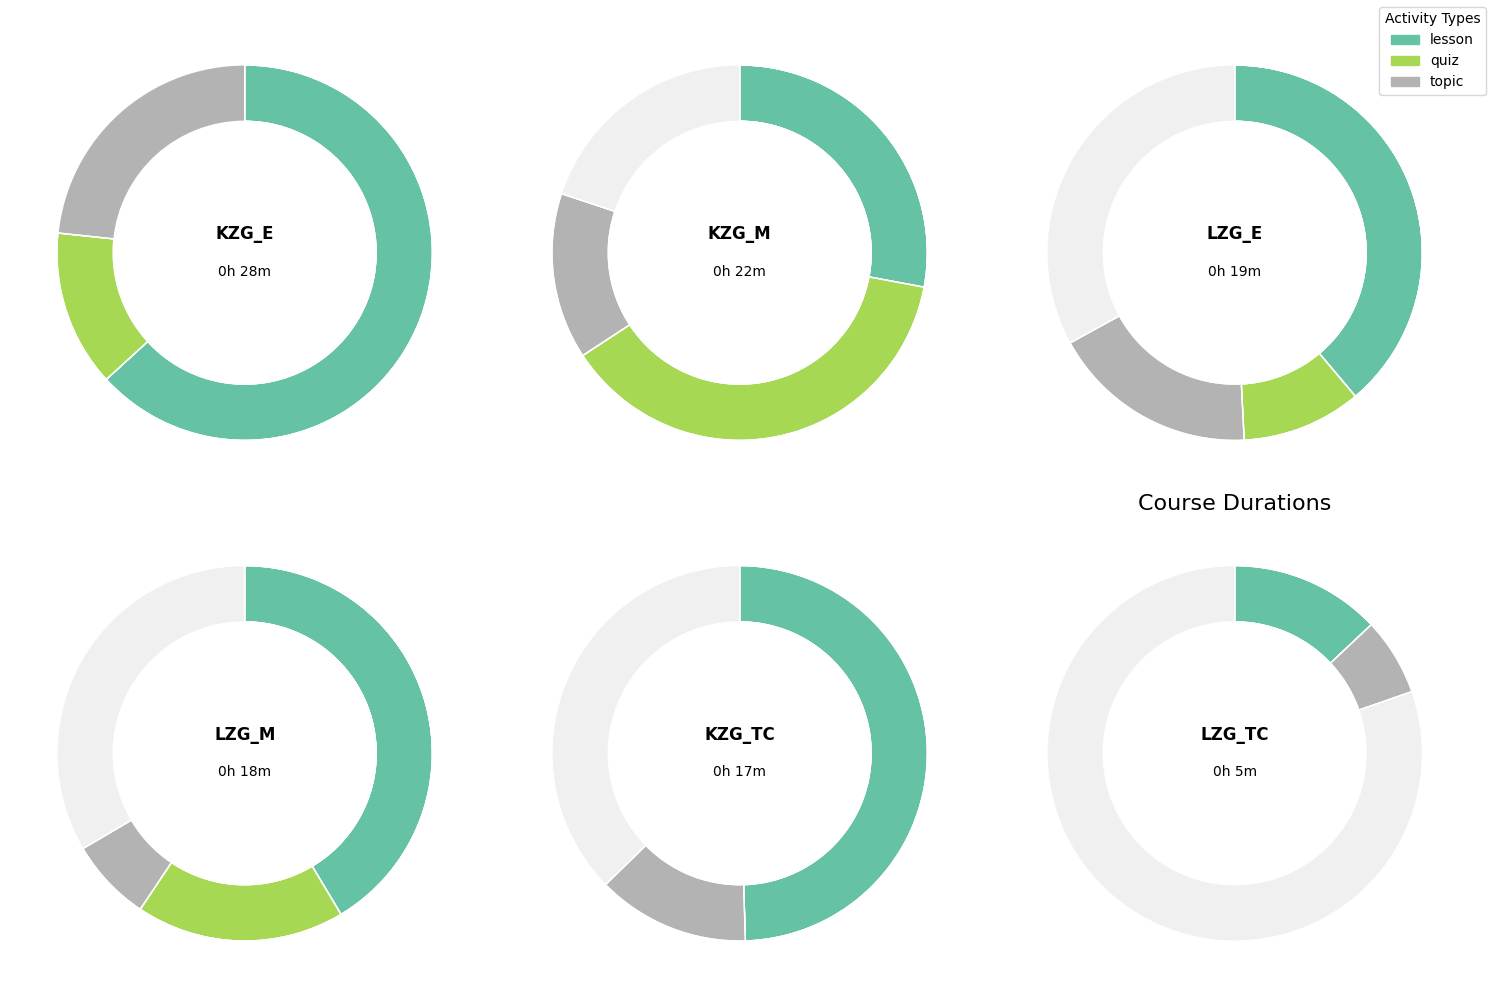

In [27]:
plot_course_durations(course_median_duration, course_map_short)

#### Mean

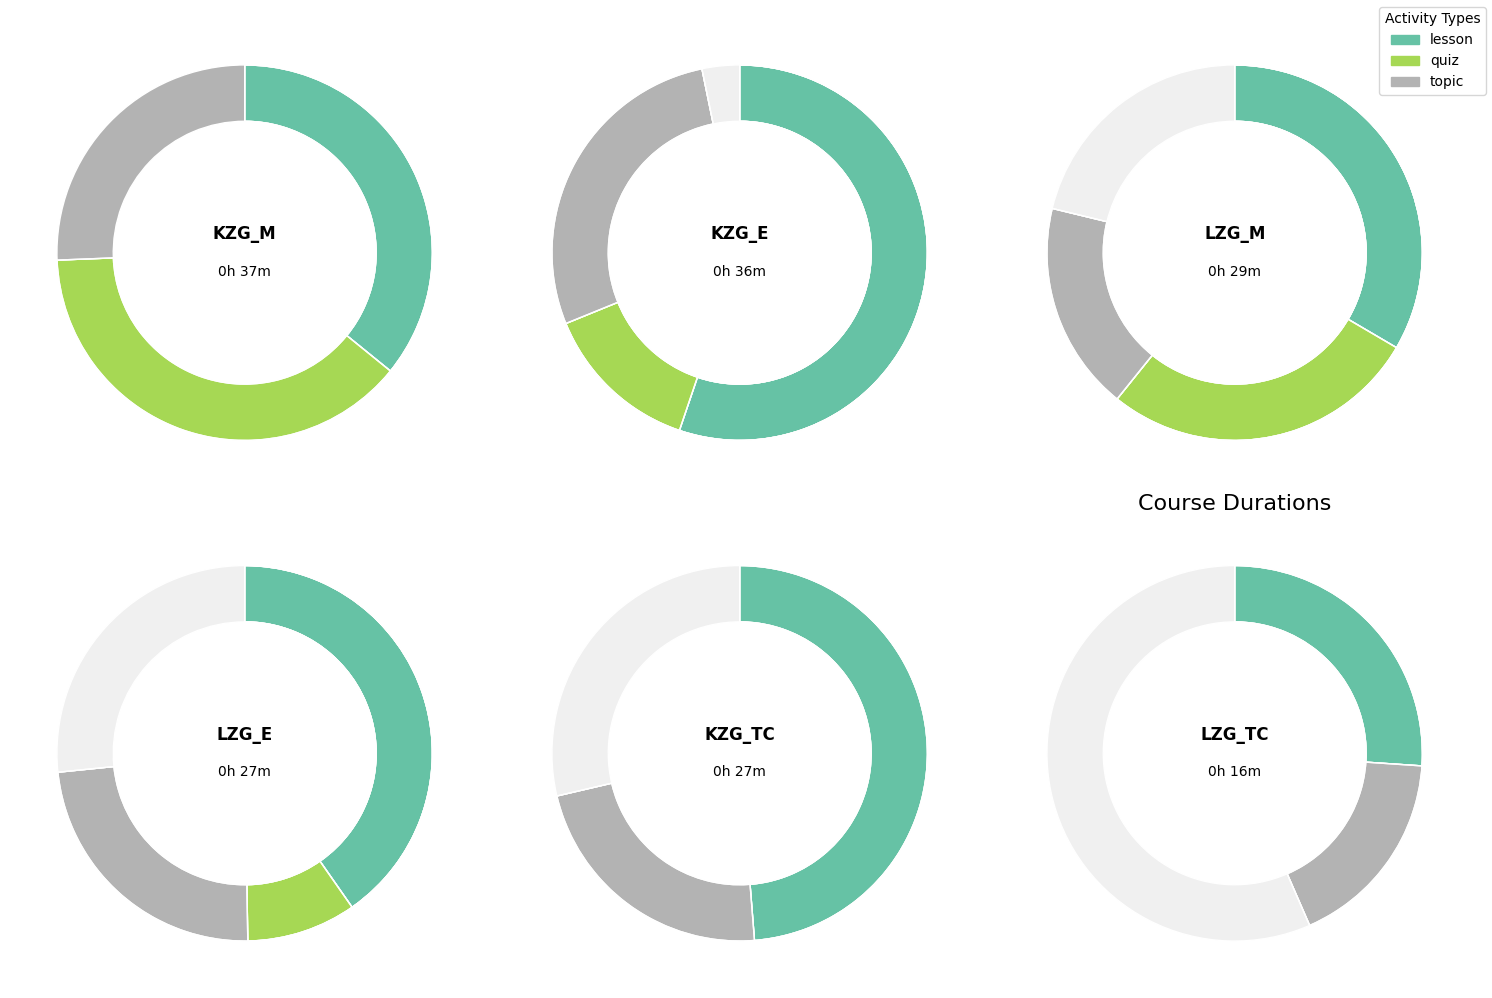

In [28]:
plot_course_durations(activities.groupby(['course_id', 'activity_type'])['duration'].mean().reset_index(), course_map_short)

### Some sanity-check prints

In [29]:
course_median_duration.activity_type.unique()

array(['lesson', 'quiz', 'topic'], dtype=object)

In [30]:
activities.columns

Index(['user_id', 'course_id', 'activity_type', 'activity_started',
       'activity_completed', 'duration', 'duration_minutes'],
      dtype='object')

In [31]:
activities.dtypes

user_id                         int64
course_id                       int64
activity_type                  object
activity_started       datetime64[ns]
activity_completed     datetime64[ns]
duration              timedelta64[ns]
duration_minutes              float64
dtype: object

In [32]:
course_median_duration.columns

Index(['course_id', 'activity_type', 'duration'], dtype='object')

In [33]:
course_median_duration.dtypes

course_id                  int64
activity_type             object
duration         timedelta64[ns]
dtype: object

In [34]:
activities.head()

,user_id,course_id,activity_type,activity_started,activity_completed,duration,duration_minutes
19,2533,42,topic,2023-04-07 16:42:38,2023-04-07 16:43:58,0 days 00:01:20,1.333333
20,2533,42,topic,2023-04-07 16:43:59,2023-04-07 16:46:13,0 days 00:02:14,2.233333
21,2533,42,topic,2023-04-07 16:46:14,2023-04-07 16:46:27,0 days 00:00:13,0.216667
22,2533,42,topic,2023-04-07 16:46:28,2023-04-07 16:48:11,0 days 00:01:43,1.716667
23,2533,42,topic,2023-04-07 16:48:12,2023-04-07 16:54:48,0 days 00:06:36,6.600000


#### Limit to only intersection of users

In [35]:
zduration_users = set(zduration_sum['user_id'])
gap_days_users = set(gap_days['user_id'])
user_chains_users = set(user_chains.keys())
zscores_users = set(zscores['user_id'])

# Find the intersection
common_users = zduration_users & gap_days_users & user_chains_users & zscores_users

# Filter each dataframe/dict to only the common users
zduration_sum = zduration_sum[zduration_sum['user_id'].isin(common_users)]
gap_days = gap_days[gap_days['user_id'].isin(common_users)]
user_chains = {k: v for k, v in user_chains.items() if k in common_users}

common_users = sorted(common_users)

# Print the number of users in the intersection
print(f'Number of users in all three: {len(common_users)}')

Number of users in all three: 501


In [36]:
# Recap dataframes we will be using after processing

# Clustering inputs
zduration_sum
gap_days
user_chains

# Validation via
zscores


,user_id,course_id,percentage,zscore
0,2533,42,14.290000,-1.298893
1,2533,42,55.560000,-0.045130
2,2533,42,10.000000,-1.429221
3,2533,42,30.000000,-0.821631
4,2533,3865,0.000000,-1.733729
...,...,...,...,...
6427,3842,5447,77.647059,0.470948
6428,3596,5447,61.176471,-0.388711
6429,3596,5447,64.705882,-0.204498
6430,3596,5447,63.529412,-0.265903


# Preparation for clustering

## Distance metric based on students' Markov models

#### Code used to validate robustness of metric using random data
Uncomment last line to test for yourself

In [37]:
def random_states(num_states, alphabet=None):
    if alphabet is None:
        import string
        alphabet = list(string.ascii_lowercase)
    import random
    return random.sample(alphabet, num_states)

def random_transition_matrix(size):
    import numpy as np
    mat = np.random.rand(size, size)
    mat /= mat.sum(axis=1, keepdims=True)
    return mat

def generate_random_user_chains(common_users, min_states=3, max_states=6):
    user_chains = {}
    for user in common_users:
        import random
        n_states = random.randint(min_states, max_states)
        states = random_states(n_states)
        matrix = random_transition_matrix(n_states)
        from pydtmc import MarkovChain
        mc = MarkovChain(matrix, states)
        user_chains[user] = mc
    return user_chains

# Example usage:
# common_users = [f"user_{i}" for i in range(10)]
user_chains_random_for_verification = generate_random_user_chains(common_users)


### Distance metric itself

In [38]:
# Global counters for reporting
js_fallback_count = 0
pen_fallback_count = 0
js_eval_total = 0
pen_eval_total = 0

def compute_js_and_penalty(c1, c2, alpha=0.5, pen_multiplier=1):
    """Returns α·JS + (1–α)·penalty for the common‐states subchain (or None)."""
    global js_fallback_count, pen_fallback_count
    global js_eval_total, pen_eval_total

    common = set(c1.states) & set(c2.states)
    if len(common) < 2:
        # Too few states to do a meaningful JS; either skip or set js=0
        return None
    else:
        # Get sub‐matrices
        idx1 = [c1.states.index(s) for s in common]
        idx2 = [c2.states.index(s) for s in common]
        P = c1.p[np.ix_(idx1, idx1)]
        Q = c2.p[np.ix_(idx2, idx2)]

        js_vals = []
        for p_row, q_row in zip(P, Q):
            sp, sq = p_row.sum(), q_row.sum()
            if sp > 0 and sq > 0:
                # normalize
                p_norm = p_row / sp
                q_norm = q_row / sq
                # account for possible underflow
                raw = jensenshannon(p_norm, q_norm, base=2)
                js_vals.append(max(raw, 0.0))

        # Track JS fallback usage
        js_eval_total += 1
        if js_vals:
            js = float(np.mean(js_vals))
        else:
            js_fallback_count += 1
            # print("Warning: js_vals is empty; using default JS = 1.0")
            js = 1.0

    # structural penalty as before
    total = set(c1.states) | set(c2.states)
    pen_eval_total += 1
    if total:
        pen = 1 - (len(common) / len(total))
    else:
        pen_fallback_count += 1
        # print("Warning: total state set is empty; using default penalty = 1.0")
        pen = 1.0
    pen = pen * pen_multiplier

    return alpha * js + (1 - alpha) * pen


def build_distance_matrix(user_chains, alpha=0.5, pen_multiplier=1):
    users = list(user_chains.keys())
    n = len(users)
    INF = float('inf')

    # 1) Initialize the “direct” distance lookup
    direct = { (u,v): (0.0 if u==v else INF)
               for u in users for v in users }

    # 2) Fill in distances for pairs with common states
    for u1, u2 in combinations(users, 2):
        dist = compute_js_and_penalty(user_chains[u1],
                                      user_chains[u2],
                                      alpha=alpha,
                                      pen_multiplier=pen_multiplier)
        if dist is not None:
            direct[(u1,u2)] = direct[(u2,u1)] = dist

    # 3) Build a graph whose edges are exactly those “direct” distances
    G = nx.Graph()
    G.add_nodes_from(users)
    for (u,v), w in direct.items():
        if u != v and w < INF:
            G.add_edge(u, v, weight=w)

    # 4) Compute all‐pairs shortest paths on G
    sp_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

    # 5) Assemble full DataFrame
    D = pd.DataFrame(INF, index=users, columns=users)
    for u in users:
        for v, d in sp_lengths[u].items():
            D.at[u, v] = d

    # 6) Count connected components (for reporting)
    n_components = nx.number_connected_components(G)

    # 7) Print fallback usage statistics
    if js_eval_total > 0:
        print(f"JS fallback used in {100 * js_fallback_count / js_eval_total:.1f}% of cases")
    if pen_eval_total > 0:
        print(f"Penalty fallback used in {100 * pen_fallback_count / pen_eval_total:.1f}% of cases")

    return D, n_components


dist_matrix, components = build_distance_matrix(user_chains, alpha=0.2,pen_multiplier=1)
print("Distance matrix:\n", dist_matrix)
print("Connected components:", components)


/opt/homebrew/Caskroom/miniconda/base/envs/gogymi/lib/python3.12/site-packages/scipy/spatial/distance.py:1391: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


JS fallback used in 0.3% of cases
Penalty fallback used in 0.0% of cases
Distance matrix:
           1         4         6         7         9         11        16    \
1     0.000000  0.377822  0.098242  0.144507  0.130248  0.980537  0.261894   
4     0.377822  0.000000  0.443728  0.387207  0.400583  1.050213  0.535532   
6     0.098242  0.443728  0.000000  0.143825  0.119494  1.062232  0.228185   
7     0.144507  0.387207  0.143825  0.000000  0.096920  1.045450  0.219580   
9     0.130248  0.400583  0.119494  0.096920  0.000000  1.028449  0.210262   
...        ...       ...       ...       ...       ...       ...       ...   
4086  0.239119  0.497336  0.219426  0.225503  0.188383  1.076557  0.057455   
4087  0.262142  0.538361  0.219496  0.239450  0.199345  1.080394  0.056349   
4089  1.105360  1.221129  1.111289  1.079715  1.064103  0.455695  1.134174   
4092  0.469443  0.585211  0.475372  0.443798  0.428186  0.683204  0.498257   
4095  0.235378  0.480000  0.219337  0.278719  0.239

### Heatmap of resulting Distance Matrix

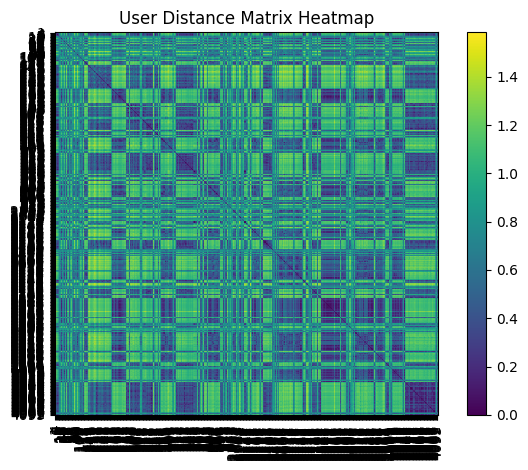

In [39]:
import matplotlib.pyplot as plt

# Assume `dist_matrix` is a pandas DataFrame of shape (n_users, n_users)
# with user IDs as both index and columns.

fig, ax = plt.subplots()
im = ax.imshow(dist_matrix.values)

# Label axes with user IDs
ax.set_xticks(range(len(dist_matrix.columns)))
ax.set_xticklabels(dist_matrix.columns, rotation=90)
ax.set_yticks(range(len(dist_matrix.index)))
ax.set_yticklabels(dist_matrix.index)

ax.set_title('User Distance Matrix Heatmap')

# Add a colorbar to interpret distances
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


#### Heatmap for random data for verification

JS fallback used in 0.2% of cases
Penalty fallback used in 0.0% of cases


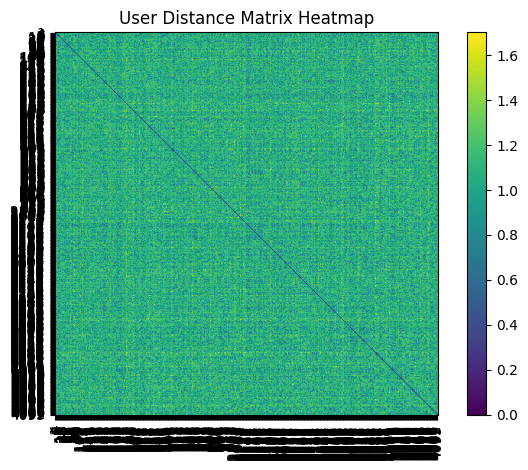

In [40]:
import matplotlib.pyplot as plt

# Assume `dist_matrix` is a pandas DataFrame of shape (n_users, n_users)
# with user IDs as both index and columns.

fig, ax = plt.subplots()
temp, _ = build_distance_matrix(user_chains_random_for_verification, alpha=0.2,pen_multiplier=1)
im = ax.imshow(temp.values)

# Label axes with user IDs
ax.set_xticks(range(len(dist_matrix.columns)))
ax.set_xticklabels(dist_matrix.columns, rotation=90)
ax.set_yticks(range(len(dist_matrix.index)))
ax.set_yticklabels(dist_matrix.index)

ax.set_title('User Distance Matrix Heatmap')

# Add a colorbar to interpret distances
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


### Visualisation explaining theory behind metric

/opt/homebrew/Caskroom/miniconda/base/envs/gogymi/lib/python3.12/site-packages/scipy/spatial/distance.py:1391: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


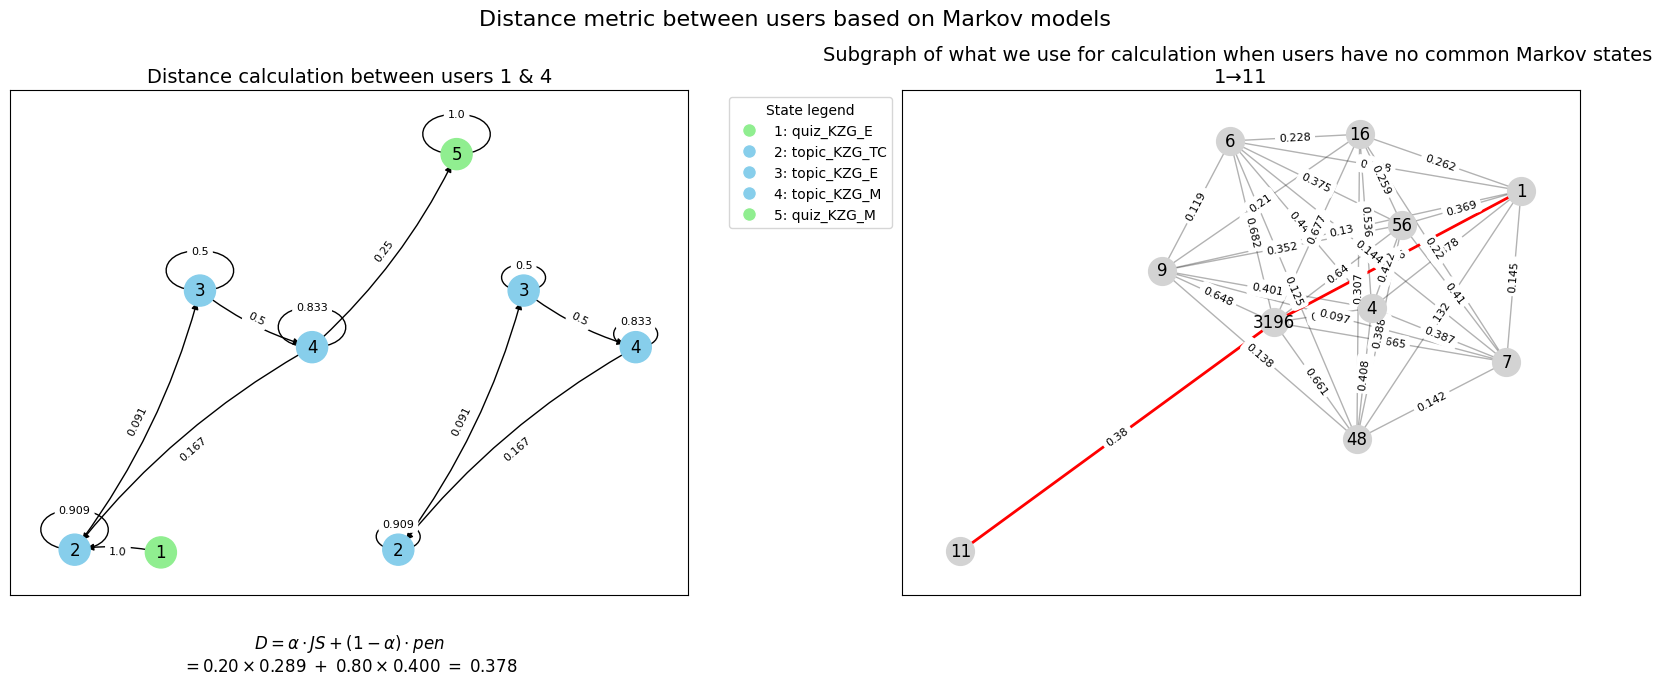

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations, islice
from scipy.spatial.distance import jensenshannon

# ── Configuration ─────────────────────────────────────────────────────────────
ALPHA    = 0.2
PEN_MULT = 1

# ── Helper functions ───────────────────────────────────────────────────────────
def extract_js_pen(chain1, chain2, alpha=ALPHA):
    common = list(set(chain1.states) & set(chain2.states))
    total  = set(chain1.states) | set(chain2.states)
    pen    = 1 - len(common) / len(total) if total else 1.0

    idx1 = [chain1.states.index(s) for s in common]
    idx2 = [chain2.states.index(s) for s in common]
    P = chain1.p[np.ix_(idx1, idx1)]
    Q = chain2.p[np.ix_(idx2, idx2)]

    js_vals = []
    for row_p, row_q in zip(P, Q):
        sp, sq = row_p.sum(), row_q.sum()
        if sp>0 and sq>0:
            js_vals.append(jensenshannon(row_p/sp, row_q/sq, base=2))
    js = float(np.mean(js_vals)) if js_vals else 1.0

    return js, pen, alpha*js + (1-alpha)*pen

def build_distance_graph(chains, alpha=ALPHA, pen_mult=PEN_MULT):
    users = list(chains.keys())
    INF   = float('inf')
    direct = {(u,v): (0.0 if u==v else INF) 
              for u in users for v in users}

    for u1,u2 in combinations(users,2):
        d = compute_js_and_penalty(chains[u1], chains[u2],
                                   alpha=alpha, pen_multiplier=pen_mult)
        if d is not None:
            direct[(u1,u2)] = direct[(u2,u1)] = d

    G = nx.Graph()
    G.add_nodes_from(users)
    for (u,v),w in direct.items():
        if u!=v and w<INF:
            G.add_edge(u, v, weight=round(w,3))
    return G, direct

def expand_to_n_nodes(G, core_nodes, n=10):
    included = set(core_nodes)
    queue = list(core_nodes)
    while queue and len(included)<n:
        v = queue.pop(0)
        for nbr in G.neighbors(v):
            if nbr not in included:
                included.add(nbr)
                queue.append(nbr)
                if len(included)>=n:
                    break
    return included

# ── Main plotting routine ─────────────────────────────────────────────────────
def plot_two_panels(user_chains, alpha=ALPHA, pen_mult=PEN_MULT):
    # 1) pick one pair WITH common states
    users = list(user_chains.keys())
    s1, s2 = next((a,b) for a,b in combinations(users,2)
                   if set(user_chains[a].states) & set(user_chains[b].states))
    c1, c2 = user_chains[s1], user_chains[s2]
    js, pen, D = extract_js_pen(c1, c2, alpha)

    # 2) build distance graph, pick pair WITHOUT common 
    G, direct = build_distance_graph(user_chains, alpha, pen_mult)
    a,b = next((u,v) for u,v in combinations(users,2)
               if direct[(u,v)]>=float('inf') 
               and v in nx.node_connected_component(G,u))
    path = nx.shortest_path(G, a, b, weight='weight')

    # 3) 10-node neighborhood around that path
    nodes10 = expand_to_n_nodes(G, path, n=10)
    subG10  = G.subgraph(nodes10).copy()

    # 4) union graph of the two chains
    H = nx.DiGraph()
    for C in (c1, c2):
        for i,u in enumerate(C.states):
            for j,v in enumerate(C.states):
                if C.p[i,j]>0:
                    H.add_edge(u,v, weight=round(C.p[i,j],3))

    # build a single layout, then split
    pos0 = nx.spring_layout(H, seed=42)
    pos1 = {n:(x*0.4-0.3,y) for n,(x,y) in pos0.items()}
    pos2 = {n:(x*0.4+0.3,y) for n,(x,y) in pos0.items()}

    # classify states
    common = set(c1.states) & set(c2.states)
    unique1 = set(c1.states)-common
    unique2 = set(c2.states)-common
    def node_color(s):
        if s in common:   return 'skyblue'
        if s in unique1:  return 'lightgreen'
        return 'lightcoral'

    # 5) remap state names → small ints for left panel
    left_states = list(c1.states) + [s for s in c2.states if s not in c1.states]
    # but only need those actually in the two plots
    left_states = list(dict.fromkeys(left_states))
    mapping = {state: idx+1 for idx, state in enumerate(left_states)}

    # 6) draw
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,7))
    fig.suptitle("Distance metric between users based on Markov models", fontsize=16)

    # — Left panel with numeric labels + legend
    for states,pos in [(c1.states,pos1),(c2.states,pos2)]:
        # nodes with numeric labels
        nx.draw_networkx_nodes(H.subgraph(states), pos,
                               node_color=[node_color(s) for s in states],
                               node_size=500, ax=ax1)
        # edges
        nx.draw_networkx_edges(H.subgraph(states), pos,
                               arrows=True, arrowstyle='-|>',
                               ax=ax1, connectionstyle='arc3,rad=0.1')
        # numeric labels
        labels_num = {s: str(mapping[s]) for s in states}
        nx.draw_networkx_labels(H.subgraph(states), pos,
                                labels=labels_num, ax=ax1)
        # edge-labels = transition probs
        edge_lbls = nx.get_edge_attributes(H.subgraph(states),'weight')
        nx.draw_networkx_edge_labels(H.subgraph(states), pos,
                                     edge_labels=edge_lbls,
                                     font_size=8, ax=ax1)

    ax1.set_title(f"Distance calculation between users {s1} & {s2}", fontsize=14)
    formula = (
        r"$D = \alpha \cdot JS + (1-\alpha)\cdot pen$" "\n"
        rf"$= {alpha:.2f}\times {js:.3f} \;+\; {1-alpha:.2f}\times {pen:.3f}"
        rf"\;=\; {D:.3f}$"
    )
    ax1.text(0.5, -0.15, formula, transform=ax1.transAxes,
             ha='center', fontsize=12)

    # legend at right of left plot
    legend_items = [plt.Line2D([0],[0], marker='o', color='w',
                     label=f"{mapping[state]}: {state}",
                     markerfacecolor=node_color(state), markersize=10)
                    for state in left_states]
    ax1.legend(handles=legend_items, bbox_to_anchor=(1.05,1),
               loc='upper left', title="State legend")

    # — Right panel: ~10-node subgraph with weights drawn *after* highlighting
    posR = nx.spring_layout(subG10, seed=24)
    # 1) nodes
    nx.draw_networkx_nodes(subG10, posR, node_color='lightgray',
                           node_size=400, ax=ax2)
    nx.draw_networkx_labels(subG10, posR, ax=ax2)
    # 2) all edges lightly
    nx.draw_networkx_edges(subG10, posR, ax=ax2, alpha=0.3)
    # 3) highlight the shortest-path edges in red
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(subG10, posR, edgelist=path_edges,
                           edge_color='r', width=2, ax=ax2)
    # 4) **now** draw all edge‐weight labels on top
    wlabels = nx.get_edge_attributes(subG10, 'weight')
    nx.draw_networkx_edge_labels(subG10, posR, edge_labels=wlabels,
                                 font_size=8, ax=ax2)
    ax2.set_title(f"Subgraph of what we use for calculation when users have no common Markov states \n{a}→{b}", fontsize=14)


    plt.tight_layout()
    plt.show()


plot_two_panels(user_chains, alpha=ALPHA, pen_mult=PEN_MULT)


## Distance metric based on students' standardized activity duration per (activity_type, course_id) pair

### Distance metric itself

In [42]:
import networkx as nx
import numpy as np

# --- Step 1: Build the bipartite graph ---
B = nx.Graph()
B.add_nodes_from(common_users, bipartite='user')
activities_list = list(
    set(tuple(x) for x in zduration_sum[['course_id', 'activity_type']].to_numpy())
)
B.add_nodes_from(activities_list, bipartite='activity')

for row in zduration_sum.itertuples(index=False):
    B.add_edge(row.user_id, (row.course_id, row.activity_type), weight=row.zscore_duration)

# --- Step 2: Build the user-user weighted graph based on shared activities ---
G_user = nx.Graph()
G_user.add_nodes_from(common_users)

n_users = len(common_users)
user_idx = {u: i for i, u in enumerate(common_users)}  # mapping for matrix

for i in range(n_users):
    for j in range(i + 1, n_users):
        u1, u2 = common_users[i], common_users[j]
        u1_acts = set(B.neighbors(u1))
        u2_acts = set(B.neighbors(u2))
        common_acts = u1_acts & u2_acts
        if common_acts:
            z1 = [B.edges[u1, act]['weight'] for act in common_acts]
            z2 = [B.edges[u2, act]['weight'] for act in common_acts]
            dist = np.linalg.norm(np.array(z1) - np.array(z2))
            G_user.add_edge(u1, u2, weight=dist)

print("Number of connected components:", nx.number_connected_components(G_user))


# Use Floyd-Warshall for all-pairs shortest path in the user-user graph
fw_matrix = nx.floyd_warshall_numpy(G_user, nodelist=common_users, weight='weight')
# fw_matrix is a numpy array, shape (n_users, n_users), with shortest distances

# Verify all distances exist properly
max_g = np.nanmax(fw_matrix[np.isfinite(fw_matrix)])
print(f"Max entry is (we are verifying no infinites): {max_g}")
# fw_matrix = np.where(np.isfinite(fw_matrix), fw_matrix, max_g * 1.1)
graph_matrix = fw_matrix

total_nans = np.isnan(graph_matrix).sum()
print(f"Total NaN values in the DataFrame: {total_nans}")


Number of connected components: 1
Max entry is (we are verifying no infinites): 4.129244781812588
Total NaN values in the DataFrame: 0


### Code that visualises theoretical explanation

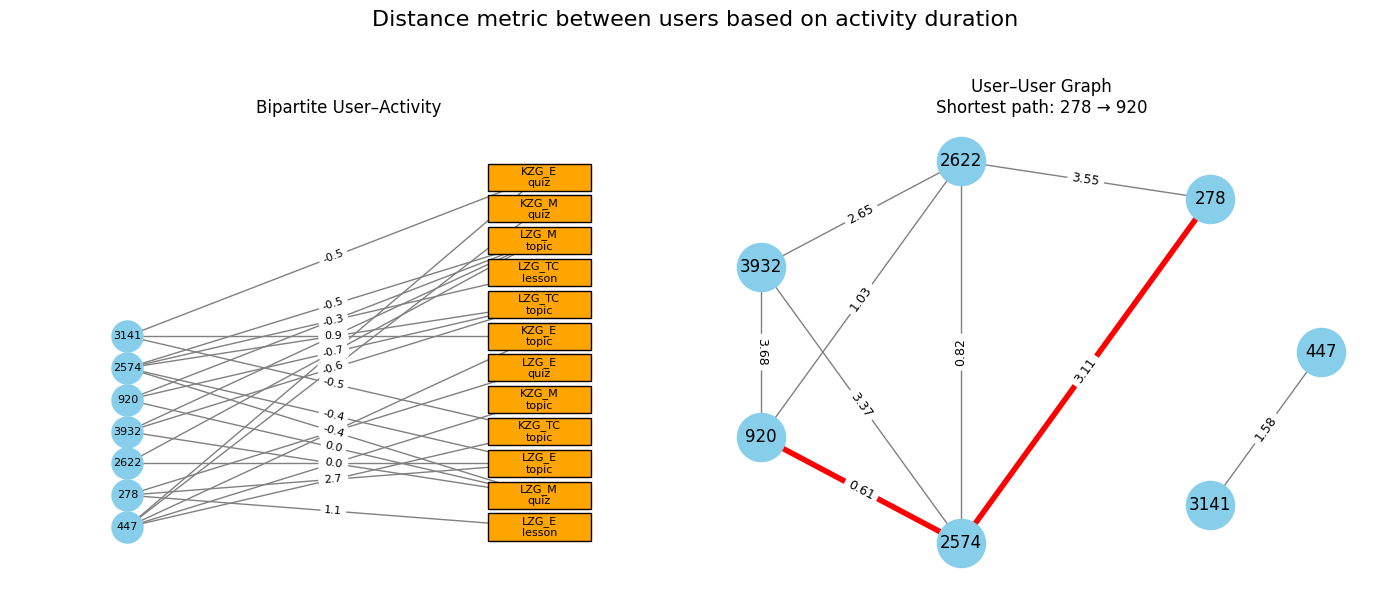

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.patches import Rectangle

# Parameters
subset_size = 7
v_spacing = 20      # vertical spacing between rows
h_spacing = 4.0    # horizontal spacing between the two node columns
user_node_size = 500   # bipartite blue nodes (20% smaller)
uu_node_size = 1200    # user–user nodes (2× default)
rect_w, rect_h = 1,17  # orange rectangles ≈ 8 chars wide × 2 text rows high

# 1–4: keep sampling/building until we have at least one disjoint pair
while True:
    # 1. Subsample users & filter
    subset_users = random.sample(common_users, min(len(common_users), subset_size))
    df_sub = zduration_sum[zduration_sum['user_id'].isin(subset_users)]
    # 2. Build bipartite graph B
    B = nx.Graph()
    B.add_nodes_from(subset_users, bipartite='user')
    activities = list({(r.course_id, r.activity_type) for r in df_sub.itertuples(False)})
    B.add_nodes_from(activities, bipartite='activity')
    for u, c, a, z in df_sub[['user_id','course_id','activity_type','zscore_duration']].itertuples(False):
        B.add_edge(u, (c, a), weight=z)
    # 3. Build user–user graph G_user
    G_user = nx.Graph()
    G_user.add_nodes_from(subset_users)
    for i, u1 in enumerate(subset_users):
        for u2 in subset_users[i+1:]:
            common = set(B.neighbors(u1)) & set(B.neighbors(u2))
            if common:
                w1 = np.array([B.edges[u1,a]['weight'] for a in common])
                w2 = np.array([B.edges[u2,a]['weight'] for a in common])
                G_user.add_edge(u1, u2, weight=np.linalg.norm(w1 - w2))
    # 4. Find disjoint‐activity pairs in the largest component
    if G_user.number_of_edges() == 0:
        continue
    cc = max(nx.connected_components(G_user), key=len)
    pairs = [
        (u1, u2)
        for u1 in cc for u2 in cc
        if u1 < u2 and set(B.neighbors(u1)).isdisjoint(B.neighbors(u2))
    ]
    if pairs:
        break

# Pick one valid pair and compute shortest path
u_start, u_end = random.choice(pairs)
path = nx.shortest_path(G_user, u_start, u_end, weight='weight')
path_edges = list(zip(path, path[1:]))

# 5. Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Distance metric between users based on activity duration", fontsize=16)

# Bipartite User–Activity (ax1)
pos1 = {u: (0, i*v_spacing) for i, u in enumerate(subset_users)}
pos1.update({a: (h_spacing, i*v_spacing) for i, a in enumerate(activities)})

# edges
nx.draw_networkx_edges(B, pos1, ax=ax1, edge_color='gray', width=1)
# user nodes
nx.draw_networkx_nodes(B, pos1, nodelist=subset_users,
                       node_color='skyblue', node_size=user_node_size, ax=ax1)
# activity rectangles
for a in activities:
    x, y = pos1[a]
    rect = Rectangle((x - rect_w/2, y - rect_h/2), rect_w, rect_h,
                     facecolor='orange', edgecolor='black', lw=1)
    ax1.add_patch(rect)

# labels
labels = {u: u for u in subset_users}
labels.update({a: f"{course_map_short[a[0]]}\n{a[1]}" for a in activities})
nx.draw_networkx_labels(B, pos1, labels=labels, font_size=8, ax=ax1)
# edge weights
elab = {(u, a): f"{B.edges[u,a]['weight']:.1f}" for u, a in B.edges()}
nx.draw_networkx_edge_labels(B, pos1, edge_labels=elab, font_size=8, ax=ax1)

ax1.set_title('Bipartite User–Activity')
ax1.axis('off')
ax1.margins(x=0.2, y=0.1)

# User–User Graph with Highlighted Shortest Path (ax2)
pos2 = nx.circular_layout(G_user)
nx.draw_networkx_nodes(G_user, pos2, node_color='skyblue',
                       node_size=uu_node_size, ax=ax2)
nx.draw_networkx_edges(G_user, pos2, ax=ax2, edge_color='gray', width=1)
nx.draw_networkx_edges(G_user, pos2, edgelist=path_edges,
                       ax=ax2, width=4, edge_color='red')
nx.draw_networkx_labels(G_user, pos2, ax=ax2)
uw_elab = {(u, v): f"{G_user.edges[u,v]['weight']:.2f}" for u, v in G_user.edges()}
nx.draw_networkx_edge_labels(G_user, pos2, edge_labels=uw_elab, font_size=9, ax=ax2)

ax2.set_title(f'User–User Graph\nShortest path: {u_start} → {u_end}')
ax2.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Dynamic time warping on students' gap days time series

In [44]:
from tslearn.metrics import dtw

# 2. gap_days DTW Distance Matrix
gap_days_map = gap_days.set_index('user_id')['gap_days'].to_dict()
gap_days_seqs = [gap_days_map[u] for u in common_users]
dtw_matrix = np.zeros((n_users, n_users))
for i in range(n_users):
    for j in range(i + 1, n_users):
        d = dtw(gap_days_seqs[i], gap_days_seqs[j])
        dtw_matrix[i, j] = dtw_matrix[j, i] = d

In [45]:
# 5. Normalize and Combine
def normalize_matrix(m):
    # flat = m[np.triu_indices_from(m, 1)]
    # m_norm = np.zeros_like(m)
    # if flat.max() > flat.min():
    #     m_norm = (m - flat.min()) / (flat.max() - flat.min())
    # return m_norm
    return (m - np.min(m)) / (np.max(m) - np.min(m))

dtw_norm = normalize_matrix(dtw_matrix)
graph_norm = normalize_matrix(graph_matrix)
combined_matrix = (dtw_norm + 2*dist_matrix  + graph_norm) / 3.0


# Clustering

Best number of clusters: 2 (silhouette score: 0.584)


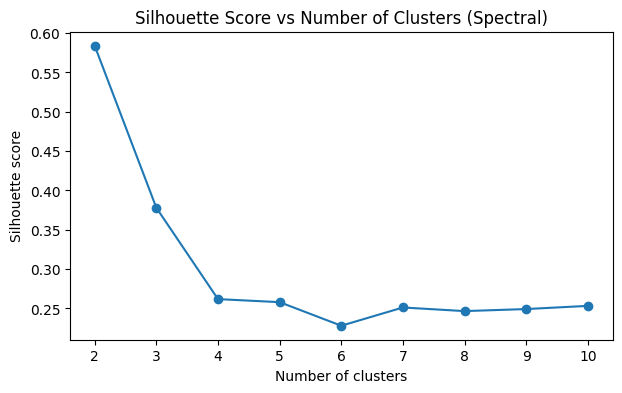

,user_id,cluster
0,1,0
1,4,0
2,6,0
3,7,0
4,9,0
...,...,...
496,4086,0
497,4087,0
498,4089,1
499,4092,0


In [46]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Convert distance matrix to similarity (kernel trick: exp(-distance^2 / (2*sigma^2)))
sigma = np.median(combined_matrix)
similarity_matrix = np.exp(-combined_matrix ** 2 / (2.0 * sigma ** 2))

range_n_clusters = range(2, min(11, len(common_users)))
sil_scores = []
best_score = -1
best_n = None
best_labels = None

for n_clusters in range_n_clusters:
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = clustering.fit_predict(similarity_matrix)
    # Silhouette expects a distance matrix, so use the original distance
    score = silhouette_score(combined_matrix, labels, metric='precomputed')
    sil_scores.append(score)
    if score > best_score:
        best_score = score
        best_n = n_clusters
        best_labels = labels

print(f"Best number of clusters: {best_n} (silhouette score: {best_score:.3f})")
plt.figure(figsize=(7, 4))
plt.plot(list(range_n_clusters), sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (Spectral)")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

cluster_df = pd.DataFrame({
    'user_id': common_users,
    'cluster': best_labels
})
display(cluster_df)

labels_spectral = best_labels


Best number of clusters (k-means): 2 (silhouette score: 0.584)


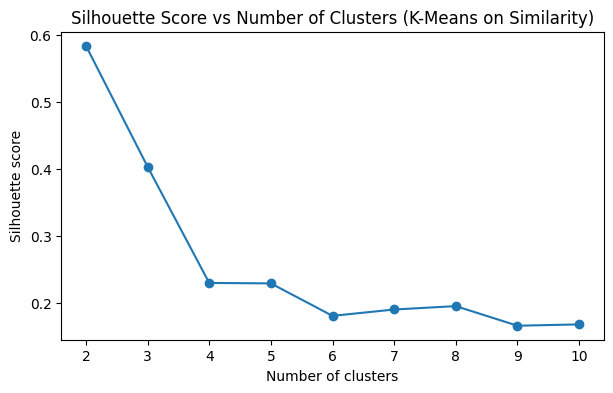

,user_id,cluster
0,1,0
1,4,0
2,6,0
3,7,0
4,9,0
...,...,...
496,4086,0
497,4087,0
498,4089,1
499,4092,0


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. build similarity exactly as before
sigma = np.median(combined_matrix)
similarity_matrix = np.exp(- combined_matrix**2 / (2.0 * sigma**2))

# 2. try k = 2…10 (or up to number of users)
range_n_clusters = range(2, min(11, len(common_users)))
sil_scores = []
best_score = -1
best_n = None
best_labels = None
best_centroids = None

for n_clusters in range_n_clusters:
    # run k-means on the rows of the similarity matrix
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels = km.fit_predict(similarity_matrix)
    
    # silhouette on your original distance matrix
    score = silhouette_score(combined_matrix, labels, metric='precomputed')
    sil_scores.append(score)
    
    if score > best_score:
        best_score = score
        best_n = n_clusters
        best_labels = labels
        best_centroids = km.cluster_centers_

# 3. report & plot
print(f"Best number of clusters (k-means): {best_n} (silhouette score: {best_score:.3f})")

plt.figure(figsize=(7,4))
plt.plot(list(range_n_clusters), sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (K-Means on Similarity)")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

# 4. assemble your DataFrame
cluster_df = pd.DataFrame({
    'user_id': common_users,
    'cluster': best_labels
})
display(cluster_df)

labels_kmeans = best_labels


### Clustering agreement

Both the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) between K-means and Spectral Clustering cluster assignments are 1.0 (the Silhouette score for best_n=2 clusters is also equal), indicating perfect agreement between the two methods for this choice of features and cluster number. This strong consistency suggests that the features may capture a robust underlying structure in the data that is recognized by both algorithms. Possible validation explored later in the notebook.

In [48]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(labels_kmeans, labels_spectral)
nmi = normalized_mutual_info_score(labels_kmeans, labels_spectral)

print(ari)
print(nmi)

1.0
1.0


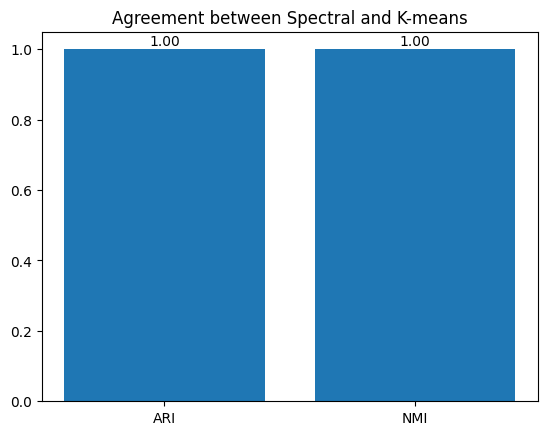

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(labels_kmeans, labels_spectral)
nmi = normalized_mutual_info_score(labels_kmeans, labels_spectral)

vals = [ari, nmi]
plt.bar(['ARI','NMI'], vals)
plt.title("Agreement between Spectral and K-means")

for i,v in enumerate(vals): plt.text(i, v+0.01, f"{v:.2f}", ha='center')
plt.show()


## Find most representative users per cluster

Cluster 0:
  Most representative (central) user_id: 306
  Closest neighbor's user_id: 301



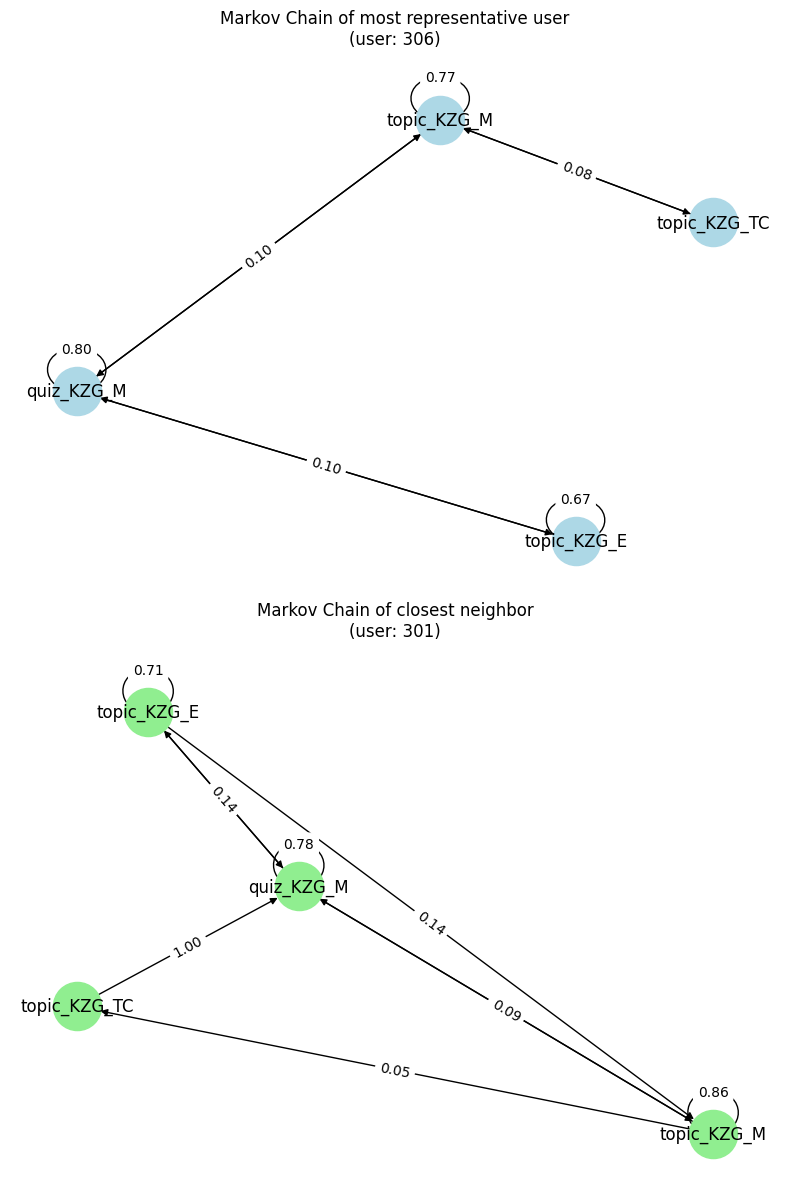

Cluster 1:
  Most representative (central) user_id: 3148
  Closest neighbor's user_id: 122



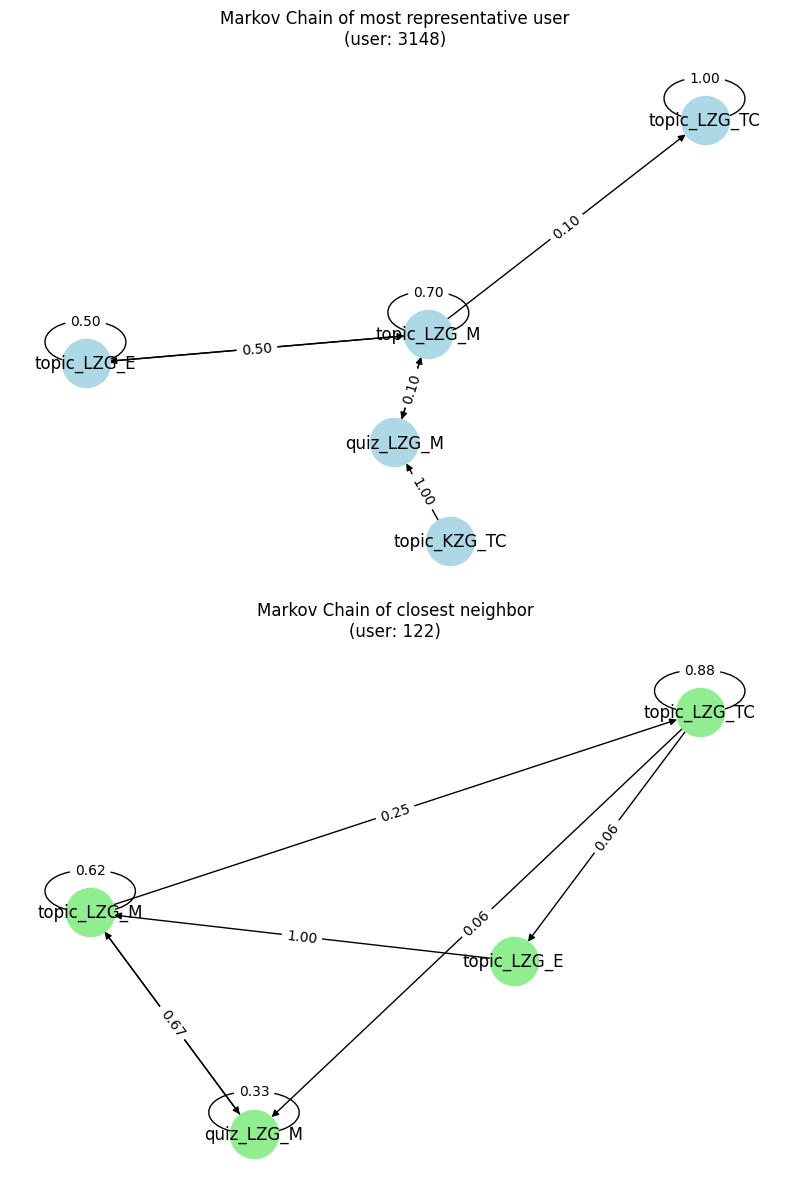

In [50]:

for k in range(best_n):
    # Get all user_ids in this cluster
    cluster_user_ids = cluster_df[cluster_df['cluster'] == k]['user_id']
    if cluster_user_ids.empty:
        continue

    # Subset similarity matrix for these users
    cluster_similarity = similarity_matrix.loc[cluster_user_ids, :]
    cluster_similarity = cluster_similarity[cluster_user_ids]  # square matrix

    # Find the most central user: row closest to cluster centroid (in similarity space)
    # Get the centroid in the full similarity space, but only care about users in this cluster
    cluster_centroid = best_centroids[k]
    centroid_restricted = pd.Series(cluster_centroid, index=similarity_matrix.columns).loc[cluster_user_ids].values
    similarity_to_centroid = np.linalg.norm(cluster_similarity.values - centroid_restricted, axis=1)
    min_idx_in_cluster = np.argmin(similarity_to_centroid)
    central_user_id = cluster_user_ids.iloc[min_idx_in_cluster]

    # For that user, find their closest neighbor (lowest distance in original combined_matrix within cluster, excluding self)
    distances_from_central = combined_matrix.loc[central_user_id, cluster_user_ids]
    distances_no_self = distances_from_central.drop(central_user_id)
    if not distances_no_self.empty:
        closest_neighbor_user_id = distances_no_self.idxmin()
    else:
        closest_neighbor_user_id = None  # only one user in cluster

    print(f"Cluster {k}:")
    print(f"  Most representative (central) user_id: {central_user_id}")
    print(f"  Closest neighbor's user_id: {closest_neighbor_user_id}\n")

    # Build central user's graph
    chain = user_chains[central_user_id]
    G = nx.DiGraph()
    for i, src in enumerate(chain.states):
        for j, dst in enumerate(chain.states):
            if chain.p[i, j] > 0:
                G.add_edge(src, dst, weight=chain.p[i, j])

    # Build closest neighbor's graph
    chain_neighbor = user_chains[closest_neighbor_user_id]
    G_neighbor = nx.DiGraph()
    for i, src in enumerate(chain_neighbor.states):
        for j, dst in enumerate(chain_neighbor.states):
            if chain_neighbor.p[i, j] > 0:
                G_neighbor.add_edge(src, dst, weight=chain_neighbor.p[i, j])

    # Create vertically stacked subplots (2 rows, 1 column)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

    # Push both subplots in from the left a bit
    fig.subplots_adjust(left=0.15)

    # …then draw your graphs as before…
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=1200, node_color='lightblue', ax=ax1)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos,
                                edge_labels={edge: f"{w:.2f}" for edge, w in labels.items()},
                                ax=ax1)
    ax1.set_title(f"Markov Chain of most representative user\n(user: {central_user_id})")

    pos_n = nx.spring_layout(G_neighbor)
    nx.draw(G_neighbor, pos_n, with_labels=True, node_size=1200, node_color='lightgreen', ax=ax2)
    labels_n = nx.get_edge_attributes(G_neighbor, 'weight')
    nx.draw_networkx_edge_labels(G_neighbor, pos_n,
                                edge_labels={edge: f"{w:.2f}" for edge, w in labels_n.items()},
                                ax=ax2)
    ax2.set_title(f"Markov Chain of closest neighbor\n(user: {closest_neighbor_user_id})")

    plt.tight_layout()
    plt.show()




## Visualise clustering

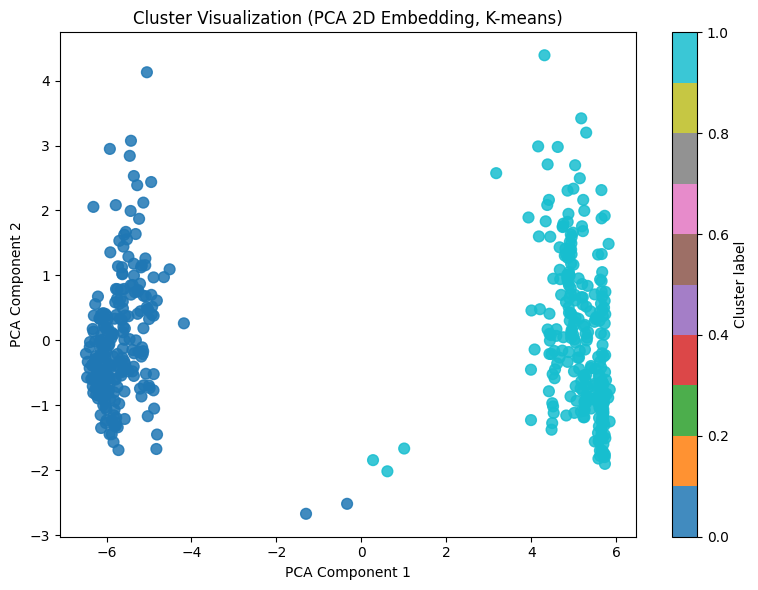

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# PCA projection to 2D
pca = PCA(n_components=2)
coords = pca.fit_transform(combined_matrix)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=labels_kmeans, cmap='tab10', s=60, alpha=0.85)
plt.title('Cluster Visualization (PCA 2D Embedding, K-means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster label')
plt.tight_layout()
plt.show()


# Results visually explained

In [52]:
def swiss_gpa(val):
    return (val/100)*5 +1

In [53]:
grades = zscores[zscores['user_id'].isin(common_users)] \
    .groupby('user_id')['percentage'] \
    .mean() \
    .apply(swiss_gpa) \
    .rename('Grade')

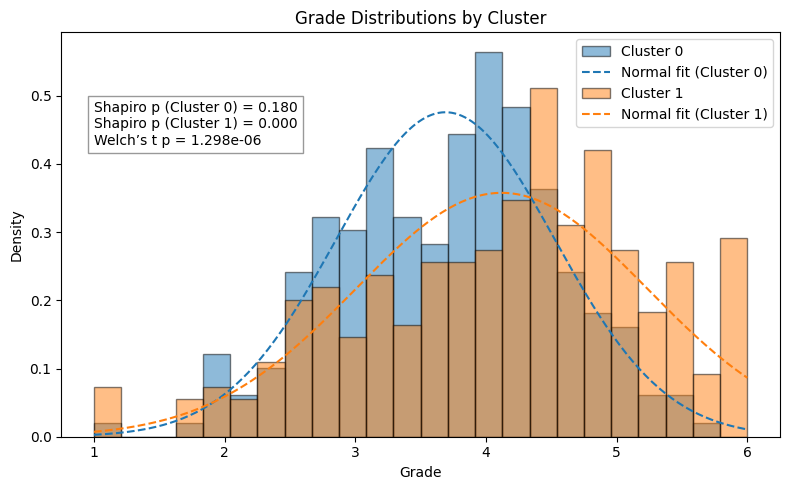

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, norm

# 1. Link user_id → Cluster and merge with grades
cluster_df = pd.DataFrame({
    'user_id': common_users,
    'Cluster': labels_kmeans
})
df = cluster_df.merge(grades, on='user_id', how='left')

# 2. Extract non‐NaN grades by cluster
grades0 = df.loc[df['Cluster'] == 0, 'Grade'].values
grades1 = df.loc[df['Cluster'] == 1, 'Grade'].values

# 3. Shapiro–Wilk tests (no length check)
W0, p0 = shapiro(grades0)
W1, p1 = shapiro(grades1)

# 4. Welch’s t‐test
t_stat, p_t = ttest_ind(grades0, grades1, equal_var=False)

# 5. Plot histograms + normal fits
min_g = min(grades0.min(), grades1.min())
max_g = max(grades0.max(), grades1.max())
x = np.linspace(min_g, max_g, 200)

mu0, s0 = grades0.mean(), grades0.std(ddof=1)
mu1, s1 = grades1.mean(), grades1.std(ddof=1)
pdf0 = norm.pdf(x, loc=mu0, scale=s0)
pdf1 = norm.pdf(x, loc=mu1, scale=s1)

plt.figure(figsize=(8, 5))
bins = np.linspace(min_g, max_g, 25)

plt.hist(
    grades0,
    bins=bins,
    density=True,
    alpha=0.5,
    color='C0',
    edgecolor='black',
    label='Cluster 0'
)
plt.plot(x, pdf0, linestyle='--', color='C0', label='Normal fit (Cluster 0)')

plt.hist(
    grades1,
    bins=bins,
    density=True,
    alpha=0.5,
    color='C1',
    edgecolor='black',
    label='Cluster 1'
)
plt.plot(x, pdf1, linestyle='--', color='C1', label='Normal fit (Cluster 1)')

# 6. Annotate p‐values
text_x = min_g
text_y = max(pdf0.max(), pdf1.max()) * 0.9
annot = (
    f"Shapiro p (Cluster 0) = {p0:.3f}\n"
    f"Shapiro p (Cluster 1) = {p1:.3f}\n"
    f"Welch’s t p = {p_t:.3e}"
)
plt.text(
    text_x,
    text_y,
    annot,
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
)

plt.title("Grade Distributions by Cluster")
plt.xlabel("Grade")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


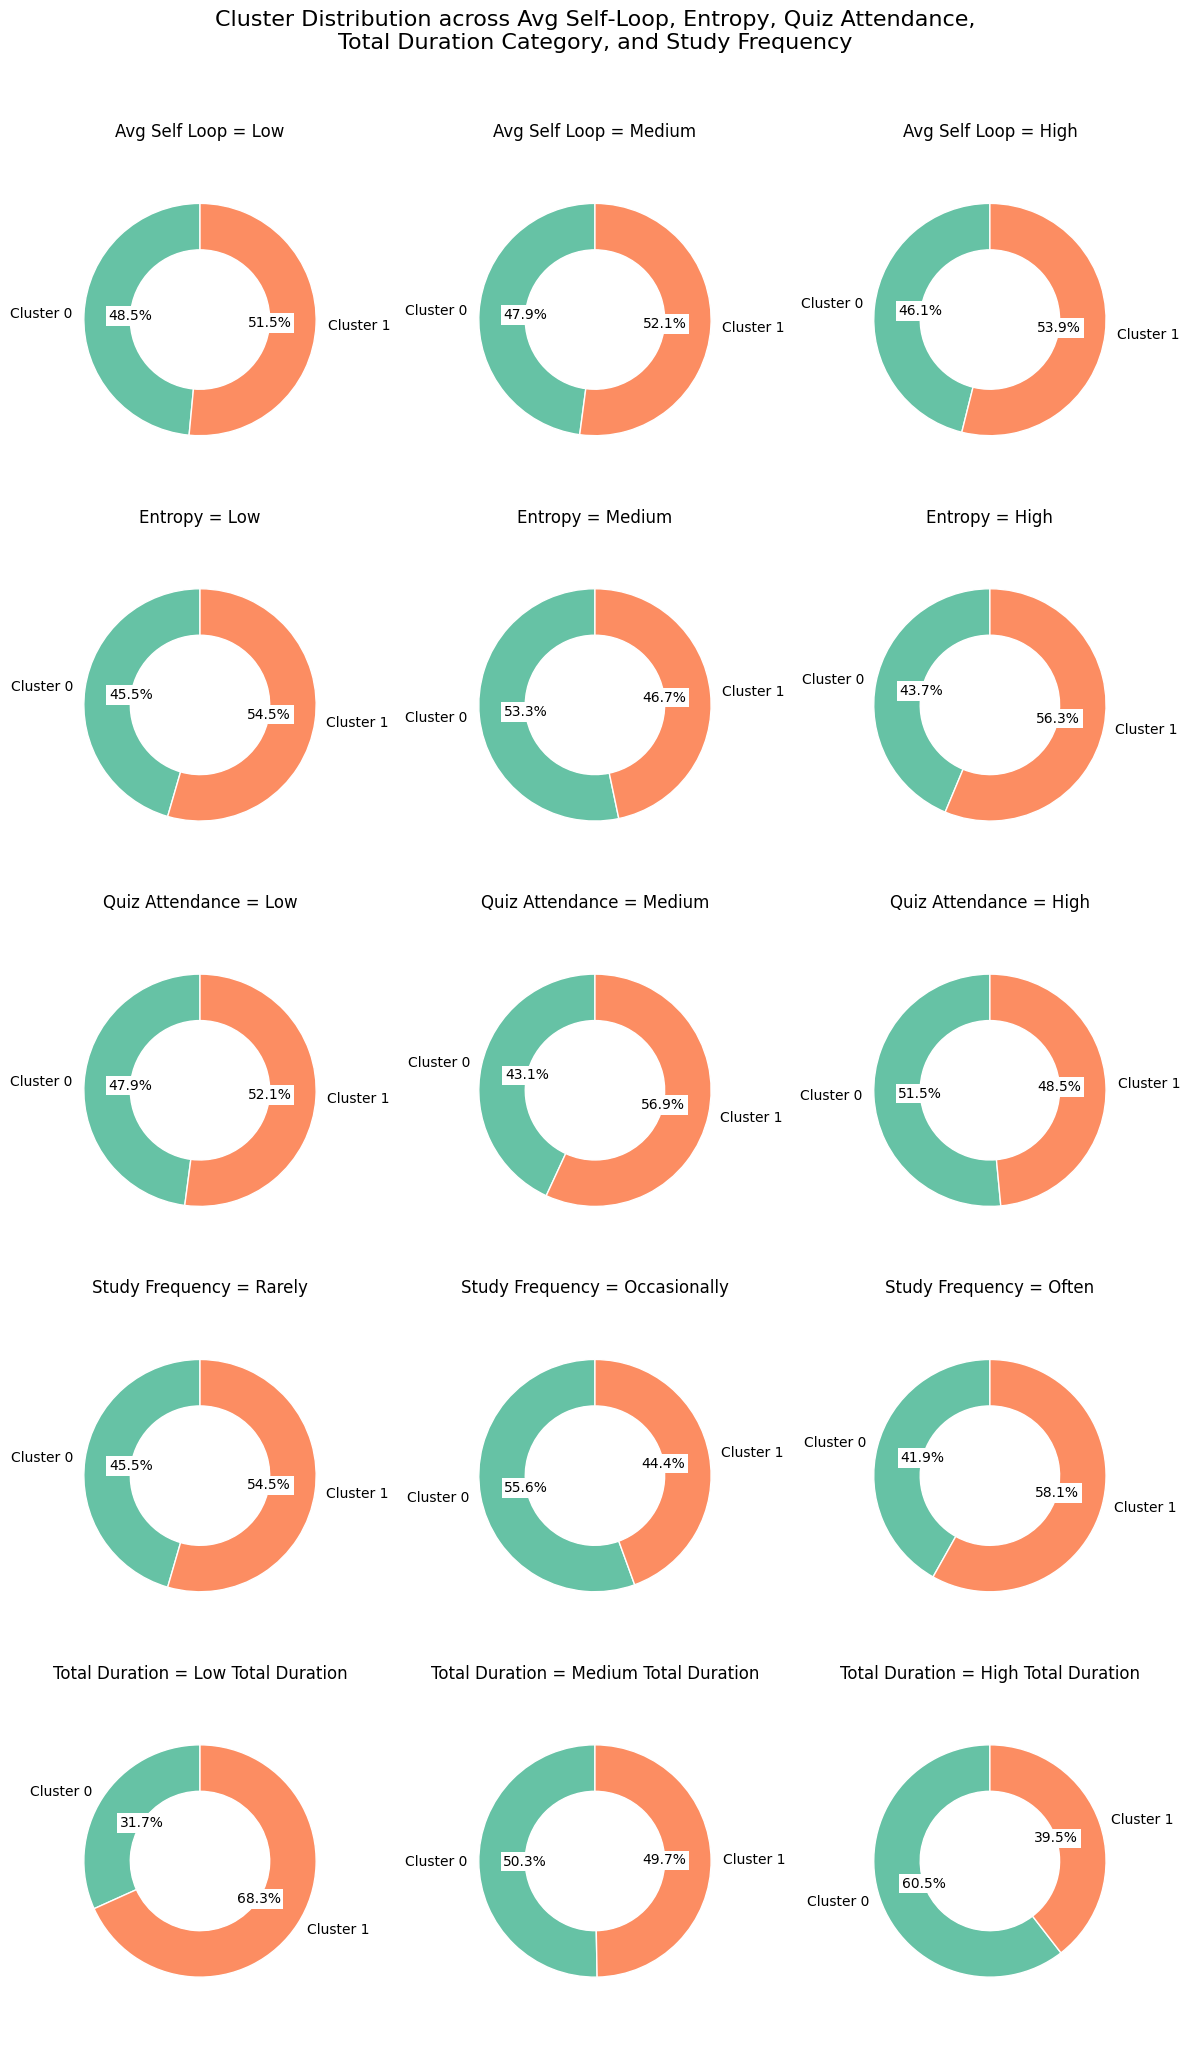

In [55]:


# -------------------------------------------------------------------------------
# 
#
#   user_chains    : dict mapping user_id → pydtmc.MarkovChain object
#   labels_kmeans  : 1D numpy array of cluster labels (0 or 1),
#                     ordered exactly to match the insertion‐order of user_chains.keys()
#   gap_days       : pandas.DataFrame with columns ["user_id", "gap_days"],
#                     where "gap_days" is an array‐like of the inter‐activity gaps (in days)
#   zduration_sum  : pandas.DataFrame computed via compute_zduration(...),
#                     having columns ["user_id", "course_id", "activity_type",
#                     "duration", "mean_duration", "std_duration", "zscore_duration"]
#                     where “duration” is a pandas Timedelta.
#
# We will compute five features per user:
#   1) avg_self_loop    – average self‐loop probability (mean of diag(chain.p))
#   2) entropy          – Shannon entropy of the stationary distribution (chain.pi)
#   3) quiz_attendance  – stationary‐weighted probability of transitioning into any state
#                        whose name contains “quiz” (case‐insensitive)
#   4) study_freq       – (“often” / “occasionally” / “rarely”) based on avg_gap from gap_days
#   5) duration_category– human‐friendly category based on total “duration” per user:
#                        (“Low Total Duration” / “Medium Total Duration” / “High Total Duration”)
#
# We need to convert each user’s Timedelta durations to a numeric measure (total seconds)
# before summing and binning.
# -------------------------------------------------------------------------------

# 0) Pre‐index gap_days for fast lookup
gap_days_indexed = gap_days.set_index("user_id")

# Convert zduration_sum.duration (Timedelta) to total seconds, then sum per user:
zd = zduration_sum.copy()
zd["duration_seconds"] = zd["duration"].dt.total_seconds()
total_duration_by_user = (
    zd.groupby("user_id")["duration_seconds"]
      .sum()
      .to_dict()
)

# 1) Loop over user_chains and compute raw metrics
user_ids      = list(user_chains.keys())
cluster_array = labels_kmeans  # shape = (N_users,), aligned with user_ids

records = []
for idx, user_id in enumerate(user_ids):
    chain   = user_chains[user_id]
    cluster = int(cluster_array[idx])  # 0 or 1

    # Transition matrix P
    P = chain.p

    # 1) avg_self_loop
    diag = np.diag(P)
    avg_self_loop = float(np.mean(diag))

    # 2) stationary distribution entropy
    try:
        pi_list = chain.pi
        if isinstance(pi_list, list) and len(pi_list) > 0:
            pi = np.array(pi_list[0], dtype=float)
        else:
            raise AttributeError
    except Exception:
        eigvals, eigvecs = np.linalg.eig(P.T)
        stat_idx = np.argmin(np.abs(eigvals - 1.0))
        vec = np.real(eigvecs[:, stat_idx])
        pi = np.abs(vec) / np.sum(np.abs(vec))
    pi_clipped = np.where(pi > 0, pi, 1e-12)
    entropy = float(-np.sum(pi_clipped * np.log(pi_clipped)))

    # 3) quiz_attendance
    try:
        state_names = list(chain.states)
    except Exception:
        state_names = []
    quiz_idx = [i for i, s in enumerate(state_names) if "quiz" in s.lower()]
    if len(quiz_idx) == 0:
        quiz_attendance = 0.0
    else:
        prob_to_quiz_from_each = P[:, quiz_idx].sum(axis=1)
        quiz_attendance = float(np.dot(pi, prob_to_quiz_from_each))

    # 4) avg_gap → study frequency
    try:
        user_gaps = gap_days_indexed.at[user_id, "gap_days"]
        avg_gap = float(np.mean(user_gaps)) if len(user_gaps) > 0 else np.nan
    except KeyError:
        avg_gap = np.nan

    # 5) total_duration → sum of duration_seconds
    total_duration = float(total_duration_by_user.get(user_id, 0.0))

    records.append({
        "user_id":         user_id,
        "cluster":         cluster,
        "avg_self_loop":   avg_self_loop,
        "entropy":         entropy,
        "quiz_attendance": quiz_attendance,
        "avg_gap":         avg_gap,
        "total_duration":  total_duration
    })

df = pd.DataFrame(records)

# 2) Bin continuous chain metrics into Low/Medium/High tertiles
cont_metrics = ["avg_self_loop", "entropy", "quiz_attendance"]
bin_labels   = ["Low", "Medium", "High"]

for m in cont_metrics:
    try:
        df[f"{m}_bin"] = pd.qcut(df[m], q=3, labels=bin_labels, duplicates="drop")
        df[f"{m}_bin"] = df[f"{m}_bin"].fillna("Low")
    except ValueError:
        low_cut = np.nanpercentile(df[m], 33.3333)
        med_cut = np.nanpercentile(df[m], 66.6667)
        def label_fn(x):
            if x <= low_cut:
                return "Low"
            elif x <= med_cut:
                return "Medium"
            else:
                return "High"
        df[f"{m}_bin"] = df[m].apply(label_fn)

# 3) Bin avg_gap into study frequency categories: often/occasionally/rarely
try:
    df["study_freq"] = pd.qcut(
        df["avg_gap"], q=3,
        labels=["often", "occasionally", "rarely"],
        duplicates="drop"
    )
    df["study_freq"] = df["study_freq"].fillna("rarely")
except ValueError:
    low_cut = np.nanpercentile(df["avg_gap"], 33.3333)
    med_cut = np.nanpercentile(df["avg_gap"], 66.6667)
    def freq_label(x):
        if np.isnan(x):
            return "rarely"
        if x <= low_cut:
            return "often"
        elif x <= med_cut:
            return "occasionally"
        else:
            return "rarely"
    df["study_freq"] = df["avg_gap"].apply(freq_label)

# 4) Bin total_duration into Low/Medium/High (human‐friendly)
try:
    df["duration_category"] = pd.qcut(
        df["total_duration"], q=3,
        labels=["Low Total Duration", "Medium Total Duration", "High Total Duration"],
        duplicates="drop"
    )
    df["duration_category"] = df["duration_category"].fillna("Low Total Duration")
except ValueError:
    low_cut = np.nanpercentile(df["total_duration"], 33.3333)
    med_cut = np.nanpercentile(df["total_duration"], 66.6667)
    def duration_label(x):
        if x <= low_cut:
            return "Low Total Duration"
        elif x <= med_cut:
            return "Medium Total Duration"
        else:
            return "High Total Duration"
    df["duration_category"] = df["total_duration"].apply(duration_label)

# 5) Plot a 5×3 grid of donut charts, with a white bbox behind percentage texts:
all_metrics = cont_metrics + ["study_freq", "duration_category"]
n_metrics   = len(all_metrics)

fig, axes = plt.subplots(n_metrics, 3, figsize=(12, 4 * n_metrics))
cluster_colors = {0: "#66c2a5", 1: "#fc8d62"}  # cluster 0 = teal, cluster 1 = coral

for row_idx, m in enumerate(all_metrics):
    if m in cont_metrics:
        # Continuous‐metric row: group by "<metric>_bin"
        grouped = (
            df.groupby([f"{m}_bin", "cluster"], observed=True)
              .size()
              .unstack(fill_value=0)
        )
        row_bins = bin_labels
        grouped = grouped.reindex(row_bins, fill_value=0)

    elif m == "study_freq":
        # Reverse order so that Rarely → Occasionally → Often
        grouped = (
            df.groupby(["study_freq", "cluster"], observed=True)
              .size()
              .unstack(fill_value=0)
        )
        row_bins = ["rarely", "occasionally", "often"]
        grouped = grouped.reindex(row_bins, fill_value=0)

    else:  # duration_category
        grouped = (
            df.groupby(["duration_category", "cluster"], observed=True)
              .size()
              .unstack(fill_value=0)
        )
        row_bins = ["Low Total Duration", "Medium Total Duration", "High Total Duration"]
        grouped = grouped.reindex(row_bins, fill_value=0)

    for col_idx, bin_name in enumerate(row_bins):
        ax = axes[row_idx, col_idx]

        if bin_name not in grouped.index:
            ax.text(0, 0, "No users", ha="center", va="center", fontsize=12)
            ax.axis("off")
            continue

        counts = grouped.loc[bin_name]
        for c in [0, 1]:
            if c not in counts.index:
                counts[c] = 0
        counts = counts.sort_index()  # ensure index = [0, 1]

        sizes = counts.values
        total = sizes.sum()
        if total == 0:
            ax.text(0, 0, "No users", ha="center", va="center", fontsize=12)
            ax.axis("off")
            continue

        labels = [f"Cluster {c}" for c in counts.index]
        colors = [cluster_colors[c] for c in counts.index]

        wedges, texts, autotexts = ax.pie(
            sizes,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            colors=colors,
            wedgeprops={"width": 0.4, "edgecolor": "white"},
            textprops={
                "fontsize": 10,
                "bbox": dict(facecolor="white", edgecolor="none", pad=2)
            }
        )
        centre_circle = plt.Circle((0, 0), 0.6, fc="white", linewidth=0)
        ax.add_artist(centre_circle)

        # Set a human‐readable title
        if m in cont_metrics:
            title_label = f"{m.replace('_', ' ').title()} = {bin_name}"
        elif m == "study_freq":
            title_label = f"Study Frequency = {bin_name.title()}"
        else:  # duration_category
            title_label = f"Total Duration = {bin_name}"
        ax.set_title(title_label, fontsize=12)
        ax.axis("equal")

plt.suptitle(
    "Cluster Distribution across Avg Self‐Loop, Entropy, Quiz Attendance,\n"
    "Total Duration Category, and Study Frequency",
    fontsize=16, y=1.02
)
plt.tight_layout()
plt.show()


## GUI to explore users' markov chains NOT PART OF THE SUBMISSION, DIDN'T make the cut, just for orientation and enjoyment

#### You can observe what each user's working on: user 22 for example is only doing long-time gymnasium essays

In [56]:
import ipywidgets as widgets
import networkx as nx
import plotly.graph_objs as go
from IPython.display import display
import numpy as np
import plotly.express as px
from networkx.drawing.nx_agraph import graphviz_layout

def plot_user_markov(user_id):
    # --- pull out the transition matrix and states ---
    mc     = user_chains[user_id]
    P      = np.array(mc.p)
    states = list(mc.states)

    # --- build directed graph of all transitions ---
    G = nx.DiGraph()
    for i, u in enumerate(states):
        for j, v in enumerate(states):
            w = round(P[i, j], 2)
            if w > 0:
                G.add_edge(u, v, weight=w)
    if G.number_of_edges() == 0:
        print(f"No transitions to plot for User {user_id}.")
        return

    # --- compute stationary distribution π (left eigenvector for λ=1) ---
    vals, vecs = np.linalg.eig(P.T)
    idx1 = np.argmin(np.abs(vals - 1.0))
    pi_raw = np.real(vecs[:, idx1])
    pi = pi_raw / pi_raw.sum()
    pi_map = {s: pi[states.index(s)] for s in states}

    # --- position nodes (Graphviz neato, else spring) ---
    try:
        rawpos = graphviz_layout(G, prog='neato')
    except:
        rawpos = nx.spring_layout(G, seed=42)
    xs = np.array([p[0] for p in rawpos.values()])
    ys = np.array([p[1] for p in rawpos.values()])
    minx, maxx = xs.min(), xs.max()
    miny, maxy = ys.min(), ys.max()
    pos = {
        n: (
            (rawpos[n][0] - minx) / (maxx - minx),
            (rawpos[n][1] - miny) / (maxy - miny),
        )
        for n in G.nodes()
    }

    # --- draw edges + arrowheads ---
    edge_traces = []
    annotations  = []
    marker_radius_px = 30   # half of marker.size=60

    for u, v, data in G.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        w       = data['weight']

        # curved if bidirectional
        rad = 0.2 if G.has_edge(v, u) and u != v else 0.0
        cx = 0.5*(x0+x1) + rad*(y1-y0)
        cy = 0.5*(y0+y1) + rad*(x0-x1)

        # main line
        edge_traces.append(go.Scatter(
            x=[x0, cx, x1], y=[y0, cy, y1],
            mode='lines',
            line=dict(color='rgba(100,100,100,0.5)', width=1.5, shape='spline'),
            hoverinfo='none', showlegend=False
        ))

        # weight label
        annotations.append(dict(
            x=cx, y=cy, text=f"{w:.2f}",
            showarrow=False,
            font=dict(size=11),
            bgcolor='rgba(255,255,255,0.8)',
            borderpad=2
        ))

        # arrowhead at 90% along the curve
        t = 0.9
        ax = (1-t)**2 * x0 + 2*(1-t)*t * cx + t**2 * x1
        ay = (1-t)**2 * y0 + 2*(1-t)*t * cy + t**2 * y1

        annotations.append(dict(
            ax=ax, ay=ay,
            x=x1, y=y1,
            axref='x', ayref='y',
            xref='x', yref='y',
            showarrow=True,
            arrowhead=2,
            arrowsize=1.2,
            arrowwidth=1.2,
            arrowcolor='rgba(100,100,100,0.6)',
            standoff=marker_radius_px
        ))

    # --- draw nodes ---
    palette = px.colors.qualitative.Plotly
    node_traces = []
    for i, n in enumerate(G.nodes()):
        x, y = pos[n]
        color = palette[i % len(palette)]
        node_traces.append(go.Scatter(
            x=[x], y=[y],
            mode='markers+text',
            marker=dict(size=60, color=color, line=dict(width=2, color='darkblue')),
            text=[f"{pi_map[n]:.2f}"],
            textposition='middle center',
            textfont=dict(size=12, color='black'),
            name=n,
            showlegend=True,
            hoverinfo='none'
        ))

    # --- assemble figure ---
    fig = go.Figure(
        data=edge_traces + node_traces,
        layout=go.Layout(
            title=f"User {user_id} Markov Model",
            title_x=0.5,
            showlegend=True,
            legend=dict(x=1.02, y=1, bordercolor='lightgray', borderwidth=1),
            margin=dict(t=50, l=25, r=150, b=25),
            hovermode='closest',
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            annotations=annotations,
            width=850, height=600,
            plot_bgcolor='rgba(245,250,255,0.5)'
        )
    )
    fig.show()

# --- interactive widget boilerplate ---
user_selector = widgets.Dropdown(
    options=sorted(user_chains.keys()),
    description='User:',
    continuous_update=False
)
out = widgets.Output()

def on_change(change):
    with out:
        out.clear_output(wait=True)
        plot_user_markov(change['new'])

user_selector.observe(on_change, names='value')
display(user_selector, out)

# auto-plot the first user to start
user_selector.value = sorted(user_chains.keys())[0]


Dropdown(description='User:', options=(1, 4, 6, 7, 9, 11, 16, 17, 20, 22, 48, 49, 55, 56, 57, 58, 62, 65, 71, …

Output()